<a href="https://colab.research.google.com/github/cbanuelos/datathon-neuroncdocs/blob/main/Inflammatory_Arthritis_Epilepsy_Model_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neurondoc Chronic Illness Project
## Inflammatory Arthritis Analysis

### Feature testing

In [11]:
# Build user-day aggregates with the cluster maps and write clustered_data.csv

import pandas as pd, numpy as np, re, gc, os
from pathlib import Path

# Paths
DATA_PATH = Path("Chronic_Illness_Dataset.csv")
MAP_COND  = Path("conditions_clusters.csv")
MAP_SYMP  = Path("symptoms_clusters.csv")
MAP_TAG   = Path("tags_clusters.csv")
MAP_FOOD  = Path("foods_clusters.csv")
MAP_TRT   = Path("treatments_clusters.csv")

OUT_DAILY = Path("clustered_data.csv")
TMP_DIR   = Path("tmp_ia_chunks")
TMP_DIR.mkdir(exist_ok=True)
for f in TMP_DIR.glob("*.csv"):
    f.unlink()  # clean stale

# CSV reader kwargs
read_kwargs = dict(
    sep=",", quotechar='"', escapechar="\\",
    engine="python", on_bad_lines="warn",
    dtype={"user_id":"string","age":"string","sex":"string","country":"string",
           "checkin_date":"string","trackable_id":"string","trackable_type":"string",
           "trackable_name":"string","trackable_value":"string"}
)

CHUNK_SIZE = 250_000
KEEP_WEATHER = ["temperature_min","temperature_max","precip_intensity","pressure","humidity"]

def _clean(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "_", str(s).strip().lower()).strip("_")

def _header_get(df, candidates):
    cols = [c for c in candidates if c in df.columns]
    return cols[0] if cols else None

def load_cluster_map(path: Path, default_best_idx: int = 1, default_orig_idx: int = 0):
    """
    Robust cluster map loader.
    - If headered: use columns like ['term_original','best_domain'].
    - Else: fall back to positional columns via .iloc (never df[:, i]).
    Returns {original_clean -> cluster_clean}.
    """
    if not path.exists():
        raise FileNotFoundError(path)
    try:
        df = pd.read_csv(path, dtype=str, sep=",", quotechar='"', escapechar="\\", engine="python", on_bad_lines="warn")
    except Exception:
        df = pd.read_csv(path, dtype=str, sep=",", header=None, quotechar='"', escapechar="\\", engine="python", on_bad_lines="warn")
    df = df.fillna("")

    orig = _header_get(df, ["term_original","original","term","raw","name","trackable_name"])
    best = _header_get(df, ["best_domain","domain","cluster","rename","best","best_name"])

    if orig is not None and best is not None:
        o = df[orig]; b = df[best]
    else:
        if not isinstance(df.columns[0], int):
            df = pd.read_csv(path, dtype=str, sep=",", header=None, quotechar='"', escapechar="\\", engine="python", on_bad_lines="warn").fillna("")
        ncols = df.shape[1]
        if default_orig_idx >= ncols or default_best_idx >= ncols:
            raise ValueError(f"{path.name}: missing expected columns; got {ncols}.")
        o = df.iloc[:, default_orig_idx]; b = df.iloc[:, default_best_idx]

    m = {}
    for oi, bi in zip(o.tolist(), b.tolist()):
        oi = _clean(oi); bi = _clean(bi)
        if oi and bi:
            m[oi] = bi
    return m

# ---------- Load maps ----------
cond_map = load_cluster_map(MAP_COND, default_best_idx=1, default_orig_idx=0)
symp_map = load_cluster_map(MAP_SYMP, default_best_idx=1, default_orig_idx=0)
tag_map  = load_cluster_map(MAP_TAG,  default_best_idx=1, default_orig_idx=0)
food_map = load_cluster_map(MAP_FOOD, default_best_idx=1, default_orig_idx=0)
trt_map  = load_cluster_map(MAP_TRT,  default_best_idx=1, default_orig_idx=0)

print("Loaded clusters:",
      f"conditions={len(set(cond_map.values()))},",
      f"symptoms={len(set(symp_map.values()))},",
      f"tags={len(set(tag_map.values()))},",
      f"foods={len(set(food_map.values()))},",
      f"treatments={len(set(trt_map.values()))}")

def chunk_to_daily(c: pd.DataFrame) -> pd.DataFrame | None:
    c = c.copy()
    c["trackable_type"] = c["trackable_type"].str.lower().str.strip()
    c["trackable_name"] = c["trackable_name"].str.lower().str.strip().map(_clean)
    c["checkin_date"]   = pd.to_datetime(c["checkin_date"], errors="coerce")
    c["day"]            = c["checkin_date"].dt.date

    pieces = []

    # Symptoms -> max severity per cluster per day
    sym = c[c["trackable_type"]=="symptom"].copy()
    if not sym.empty:
        sym["cluster"] = sym["trackable_name"].map(symp_map)
        sym = sym.dropna(subset=["cluster"])
        sym["val"] = pd.to_numeric(sym["trackable_value"], errors="coerce").clip(0, 10)
        S = sym.groupby(["user_id","day","cluster"])["val"].max().unstack("cluster")
        if S is not None and S.shape[1] > 0:
            S.columns = [f"symc__{_clean(col)}" for col in S.columns]
            pieces.append(S.reset_index())

    # Conditions -> max severity per cluster per day
    con = c[c["trackable_type"]=="condition"].copy()
    if not con.empty:
        con["cluster"] = con["trackable_name"].map(cond_map)
        con = con.dropna(subset=["cluster"])
        con["val"] = pd.to_numeric(con["trackable_value"], errors="coerce").clip(0, 10)
        C = con.groupby(["user_id","day","cluster"])["val"].max().unstack("cluster")
        if C is not None and C.shape[1] > 0:
            C.columns = [f"condc__{_clean(col)}" for col in C.columns]
            pieces.append(C.reset_index())

    # Tags / Foods / Treatments -> presence 0/1 per cluster per day
    def presence_block(df, fmap, prefix):
        if df.empty: return None
        df["cluster"] = df["trackable_name"].map(fmap)
        df = df.dropna(subset=["cluster"])
        T = df.groupby(["user_id","day","cluster"]).size().unstack("cluster").fillna(0).astype(int)
        if T is not None and T.shape[1] > 0:
            T.columns = [f"{prefix}__{_clean(col)}" for col in T.columns]
            return T.reset_index()
        return None

    tag = presence_block(c[c["trackable_type"]=="tag"].copy(),        tag_map,  "tagc")
    fod = presence_block(c[c["trackable_type"]=="food"].copy(),       food_map, "foodc")
    trt = presence_block(c[c["trackable_type"]=="treatment"].copy(),  trt_map,  "trtc")
    for p in [tag, fod, trt]:
        if p is not None: pieces.append(p)

    # Weather -> daily mean numeric
    we = c[c["trackable_type"]=="weather"].copy()
    if not we.empty:
        we = we[we["trackable_name"].isin(KEEP_WEATHER)].copy()
        we["val"] = pd.to_numeric(we["trackable_value"], errors="coerce")
        W = we.groupby(["user_id","day","trackable_name"])["val"].mean().unstack("trackable_name")
        if W is not None and W.shape[1] > 0:
            for base in KEEP_WEATHER:
                if base in W.columns:
                    W.rename(columns={base: f"x_w_{base}"}, inplace=True)
            pieces.append(W.reset_index())

    if not pieces:
        return None
    out = pieces[0]
    for p in pieces[1:]:
        out = out.merge(p, on=["user_id","day"], how="outer")
    return out

# ---------- Stream the tall file into chunk-level daily summaries ----------
if not DATA_PATH.exists():
    raise FileNotFoundError(f"{DATA_PATH.resolve()} not found. Upload it.")

n_written = 0; total_rows = 0
for i, chunk in enumerate(pd.read_csv(DATA_PATH, chunksize=CHUNK_SIZE, **read_kwargs)):
    total_rows += len(chunk)
    d = chunk_to_daily(chunk)
    del chunk; gc.collect()
    if d is None or d.empty:
        continue
    (TMP_DIR / f"ia_chunk_{i:05d}.csv").write_text(d.to_csv(index=False))
    n_written += 1
    del d; gc.collect()

print(f"Total rows read: {total_rows:,}  |  daily chunks written: {n_written}")

# Combine chunk files -> clustered_data.csv
if n_written == 0:
    raise RuntimeError("No chunk outputs were produced—check cluster maps and trackable names.")

dfs = []
for f in sorted(TMP_DIR.glob("ia_chunk_*.csv")):
    dfs.append(pd.read_csv(f))
D = pd.concat(dfs, ignore_index=True); del dfs; gc.collect()

# aggregate again just in case a user-day spilled across chunks
w_cols = [c for c in D.columns if c.startswith("x_w_")]
id_cols = ["user_id","day"]
num_cols = [c for c in D.columns if c not in id_cols]

D_w = D[id_cols + w_cols].copy()
D_o = D[id_cols + [c for c in num_cols if c not in w_cols]].copy()

Gw = D_w.groupby(id_cols)[w_cols].mean() if w_cols else pd.DataFrame(index=D_w.groupby(id_cols).size().index)
Go = D_o.groupby(id_cols).max()

daily = Go.join(Gw, how="outer").reset_index()

# Calendar features
daily["date"]  = pd.to_datetime(daily["day"])
daily["dow"]   = daily["date"].dt.weekday
for k in range(7):
    daily[f"dow_{k}"] = (daily["dow"]==k).astype(int)
daily["x_m_sin"] = np.sin(2*np.pi*daily["date"].dt.month/12.0).astype("float32")
daily["x_m_cos"] = np.cos(2*np.pi*daily["date"].dt.month/12.0).astype("float32")

daily.to_csv(OUT_DAILY, index=False)
print(f"Daily clusters saved -> {OUT_DAILY}  |  shape={daily.shape}")
daily.head(3)


Loaded clusters: conditions=63, symptoms=49, tags=26, foods=21, treatments=16
Total rows read: 7,976,223  |  daily chunks written: 32
Daily clusters saved -> clustered_data.csv  |  shape=(378439, 193)


,user_id,day,symc__adhd_attention,symc__allergy_hypersensitivity,symc__anxiety_fear_panic,symc__appetite_weight_change,symc__arthritis_inflammatory_joint,symc__autonomic_pots_syncope,symc__bleeding_bruising,symc__cardiac_chest_palpitations,...,dow,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,x_m_sin,x_m_cos
0,QEVuQwEA++2fi8XAwh3BnSEwL172Dg==,2019-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6,0,0,0,0,0,0,1,-0.866025,-0.5
1,QEVuQwEA++2fi8XAwh3BnSEwL172Dg==,2019-08-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,-0.866025,-0.5
2,QEVuQwEA++2fi8XAwh3BnSEwL172Dg==,2019-08-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,1,0,0,0,0,0,-0.866025,-0.5


In [12]:
# Cohorted IA setup: build next-day IA label from union of cond+symptom IA clusters;
# cohort to users who ever log IA (>=1), engineer history & compact weather, and summarize prevalence.

import numpy as np, pandas as pd, matplotlib.pyplot as plt, gc
from pathlib import Path

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load the daily user-day panel with the new cluster maps
D = pd.read_csv("clustered_data.csv", parse_dates=["date"]).sort_values(["user_id","date"]).reset_index(drop=True)

# Identify IA-related columns (union across conditions & symptoms)
# We conservatively require both 'arthrit' and 'inflam' in the column name.
ia_cols = [c for c in D.columns if ("arthrit" in c) and ("inflam" in c)]
if not ia_cols:
    raise RuntimeError("No IA cluster columns found. Expect columns like 'symc__arthritis_inflammatory_joint' or 'condc__inflammatory_arthritis'.")

print(f"IA union source columns (cond+symptom): {ia_cols}")

# IA severity today = max across IA condition- and symptom-based clusters
D["IA_severity_today"] = D[ia_cols].max(axis=1, skipna=True)

# Define labels: 'high today' and 'high tomorrow' (threshold=3)
D["IA_high_today"] = (D["IA_severity_today"] >= 3).astype("int8")
D["IA_high_next"]  = D.groupby("user_id")["IA_high_today"].shift(-1)

# Cohort to 'IA-engaged' users: any IA >= 1 at least once, using union above
COHORT_RULE = "any_IA_ge1"   # options: "any_IA_ge1", "any_IA_ge3"
if COHORT_RULE == "any_IA_ge1":
    keep_users = D.groupby("user_id")["IA_severity_today"].max().ge(1)
elif COHORT_RULE == "any_IA_ge3":
    keep_users = D.groupby("user_id")["IA_severity_today"].max().ge(3)
else:
    raise ValueError("COHORT_RULE must be 'any_IA_ge1' or 'any_IA_ge3'.")

D = D[D["user_id"].isin(keep_users[keep_users].index)].copy()

# IA history features: 7-day mean, EWMA14, and 1-day delta
D["IA_mean_7d"] = (D.groupby("user_id")["IA_severity_today"].transform(lambda s: s.rolling(7, min_periods=1).mean()))
D["IA_EWMA14"]  = (D.groupby("user_id")["IA_severity_today"].transform(lambda s: s.ewm(span=14, adjust=False, min_periods=1).mean()))
D["IA_delta_1d"] = D.groupby("user_id")["IA_severity_today"].diff()

# Weather compactors: DLI for temperature (0.4,0.3,0.2,0.1) and a couple z-scores
if "x_w_temperature_max_DLI" not in D.columns and "x_w_temperature_max" in D.columns:
    for k in [0,1,2,3]:
        D[f"x_w_temperature_max_lag{k}"] = D.groupby("user_id")["x_w_temperature_max"].shift(k)
    D["x_w_temperature_max_DLI"] = (
        0.4*D["x_w_temperature_max_lag0"] + 0.3*D["x_w_temperature_max_lag1"]
      + 0.2*D["x_w_temperature_max_lag2"] + 0.1*D["x_w_temperature_max_lag3"]
    )

# user-normalized weather
for base in ["x_w_temperature_max","x_w_temperature_min","x_w_humidity","x_w_pressure","x_w_precip_intensity"]:
    if base in D.columns:
        mu = D.groupby("user_id")[base].transform("mean")
        sd = D.groupby("user_id")[base].transform("std").replace(0, np.nan)
        D[base+"_z"] = (D[base] - mu) / sd

# Seasonality
if "x_m_cos" not in D.columns:
    D["x_m_cos"] = np.cos(2*np.pi*D["date"].dt.month/12.0).astype("float32")
if "x_m_sin" not in D.columns:
    D["x_m_sin"] = np.sin(2*np.pi*D["date"].dt.month/12.0).astype("float32")

# Keep rows with next-day labels only
D = D.dropna(subset=["IA_high_next"]).reset_index(drop=True)
y = D["IA_high_next"].astype(int).values
groups = D["user_id"].astype("string").values

# Summarize cohort & base rate
n_users_all = D["user_id"].nunique()
prev = float(y.mean())
print(f"[IA Cohort] users={n_users_all} rows={len(D)}  prevalence(y=1)={prev:.3%}  rule={COHORT_RULE}")

# peek at columns that look like IA-related MSK symptoms for later feature selection
msk_cols = [c for c in D.columns if ("symc__msk" in c) or ("joint" in c)]
print("MSK-like symptom columns (FYI):", sorted(msk_cols)[:10], "..." if len(msk_cols)>10 else "")


IA union source columns (cond+symptom): ['symc__arthritis_inflammatory_joint', 'condc__inflammatory_arthritis']
[IA Cohort] users=2629 rows=42426  prevalence(y=1)=18.352%  rule=any_IA_ge1
MSK-like symptom columns (FYI): ['condc__joint_limb_pain', 'symc__arthritis_inflammatory_joint', 'symc__msk_back_neck', 'symc__msk_joint_limb', 'symc__msk_myalgia_widespread'] 


In [ ]:
# Build the candidate feature matrix, run group-aware LightGBM CV, calibrate,
# compute gain, permutation AUC drop, SHAP-like contributions, and a consensus rank.

import numpy as np, pandas as pd, matplotlib.pyplot as plt, json, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    roc_curve, precision_recall_curve, auc
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
import lightgbm as lgb

# Candidate features (wide)
cand_cols = []
# all cluster families:
cand_cols += [c for c in D.columns if c.startswith(("symc__","condc__","tagc__","foodc__","trtc__"))]
# IA history & severity:
cand_cols += [c for c in ["IA_severity_today","IA_mean_7d","IA_EWMA14","IA_delta_1d"] if c in D.columns]
# weather & compactors:
cand_cols += [c for c in D.columns if c.startswith("x_w_")]
# seasonality / calendar (day-of-week dummies are allowed; we’ll judge them via permutation)
cand_cols += [c for c in D.columns if c.startswith("dow_")]
cand_cols += [c for c in ["x_m_sin","x_m_cos"] if c in D.columns]

X_all = D[cand_cols].apply(pd.to_numeric, errors="coerce").astype("float32")
print(f"#candidate features: {X_all.shape[1]}")

# Univariate screening (handles sparse/binary)
def spearman_fast(x, y):
    xr = pd.Series(x).rank(method="average"); yr = pd.Series(y).rank(method="average")
    xr = xr - xr.mean(); yr = yr - yr.mean()
    denom = (xr.std(ddof=0) * yr.std(ddof=0))
    if denom == 0 or np.isnan(denom): return np.nan
    return float((xr*yr).mean() / denom)

def univariate_oof_scores(X, y, groups, n_splits=5, seed=42):
    gkf = GroupKFold(n_splits=n_splits)
    rows = []
    for col in X.columns:
        x = X[col].values
        uniq = pd.Series(x[np.isfinite(x)]).nunique()
        if uniq < 2:
            rows.append([col, np.nan, np.nan, np.nan, np.nan]); continue

        oof = np.zeros_like(y, dtype=float); valid_any = False
        for tr, va in gkf.split(X, y, groups):
            xv = x[va]
            uv = pd.Series(xv[np.isfinite(xv)]).nunique()
            if uv == 2:
                vals = pd.Series(x[tr]); ytr = y[tr]
                p1 = ytr[vals==1].mean() if (vals==1).any() else ytr.mean()
                p0 = ytr[vals==0].mean() if (vals==0).any() else ytr.mean()
                score = np.where(xv==1, p1, p0).astype(float)
            else:
                r = pd.Series(xv).rank(method="average").values
                score = (r - r.min()) / (r.max() - r.min() + 1e-9)
            if np.isfinite(score).any():
                oof[va] = score; valid_any = True

        if valid_any:
            try:
                auc1 = roc_auc_score(y, oof); apr1 = average_precision_score(y, oof)
            except ValueError:
                auc1, apr1 = np.nan, np.nan
        else:
            auc1, apr1 = np.nan, np.nan

        x_mi = np.nan_to_num(x, copy=False)
        try:
            mi = mutual_info_classif(x_mi.reshape(-1,1), y, discrete_features=False, random_state=seed)[0]
        except Exception:
            mi = np.nan

        rho = spearman_fast(x, y)
        rows.append([col, auc1, apr1, mi, rho])

    return pd.DataFrame(rows, columns=["feature","uni_AUC","uni_AUPR","MI","Spearman"]).set_index("feature")

univar = univariate_oof_scores(X_all, y, groups, n_splits=5, seed=RANDOM_STATE)

# Group-aware LightGBM CV
def run_lgbm_groupcv(X, y, groups, n_splits=5, num_boost_round=2000, early_stopping=200, seed=42):
    gkf = GroupKFold(n_splits=n_splits)
    oof = np.zeros(len(y), dtype=float)
    models, iters, folds = [], [], []
    gain_imp = pd.Series(0.0, index=X.columns, dtype=float)

    for k, (tr, va) in enumerate(gkf.split(X, y, groups), 1):
        Xtr, ytr = X.iloc[tr], y[tr]
        Xva, yva = X.iloc[va], y[va]
        pos, neg = ytr.sum(), len(ytr)-ytr.sum()
        spw = (neg / max(pos,1))  # class balance by fold

        params = dict(
            objective="binary", metric="auc",
            learning_rate=0.03, num_leaves=255,
            min_data_in_leaf=60, feature_fraction=0.9, bagging_fraction=0.9, bagging_freq=1,
            lambda_l2=1.0, max_depth=-1, n_jobs=-1, random_state=seed,
            scale_pos_weight=spw, verbose=-1
        )
        clf = lgb.LGBMClassifier(**params, n_estimators=num_boost_round)
        clf.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)], eval_metric="auc",
            callbacks=[lgb.early_stopping(stopping_rounds=early_stopping, verbose=False)]
        )
        bi = clf.best_iteration_ or num_boost_round
        models.append(clf); iters.append(bi); folds.append((tr,va))

        p = clf.predict_proba(Xva, num_iteration=bi)[:,1]
        oof[va] = p

        print(f"[Fold {k}] AUC={roc_auc_score(yva,p):.3f}  AUPR={average_precision_score(yva,p):.3f}  best_iter={bi}")

        gain_imp += pd.Series(clf.booster_.feature_importance(importance_type="gain", iteration=bi), index=X.columns).fillna(0.0)

    # OOF metrics & calibration
    auroc = roc_auc_score(y, oof)
    aupr  = average_precision_score(y, oof)
    brier = brier_score_loss(y, oof)

    ir = IsotonicRegression(out_of_bounds="clip")
    ir.fit(oof, y)
    oof_cal = ir.predict(oof)
    brier_cal = brier_score_loss(y, oof_cal)

    return dict(
        oof=oof, oof_cal=oof_cal, models=models, iters=np.array(iters), folds=folds,
        gain=gain_imp, auroc=auroc, aupr=aupr, brier=brier, brier_cal=brier_cal, calibrator=ir
    )

cv_all = run_lgbm_groupcv(X_all, y, groups, n_splits=5, num_boost_round=2000, early_stopping=200, seed=RANDOM_STATE)

# Report cohort-aware headline metrics
prev = y.mean()
lift = cv_all["aupr"] / max(prev, 1e-9)
brier_climo = prev*(1 - prev)  # climatology Brier = p*(1-p)
bss = 1 - cv_all["brier"] / brier_climo

print("\nOOF metrics (IA, cohorted, all candidates):")
print("  AUROC = %.3f" % cv_all["auroc"])
print("  AUPR  = %.3f  (baseline=%.3f  lift=%.1fx)" % (cv_all["aupr"], prev, lift))
print("  Brier = %.3f  |  Brier Skill Score vs climatology = %.2f" % (cv_all["brier"], bss))
print("  Calibrated Brier = %.3f" % cv_all["brier_cal"])

# Permutation AUC drop (on top-50 by gain to keep it fast)
from copy import deepcopy
gain_sorted = cv_all["gain"].sort_values(ascending=False)
topK = gain_sorted.head(50).index.tolist()

def perm_drop_auc(X, y, cv_obj, feat_list):
    drops = pd.Series(0.0, index=feat_list); counts = pd.Series(0, index=feat_list)
    for (tr, va), model, bi in zip(cv_obj["folds"], cv_obj["models"], cv_obj["iters"]):
        Xva = X.iloc[va].copy()
        base_auc = roc_auc_score(y[va], model.predict_proba(Xva, num_iteration=bi)[:,1])
        rng = np.random.RandomState(42)
        for f in feat_list:
            xx = Xva.copy()
            xx[f] = rng.permutation(xx[f].values)
            p = model.predict_proba(xx, num_iteration=bi)[:,1]
            drops[f] += (base_auc - roc_auc_score(y[va], p)); counts[f] += 1
    return (drops / counts.replace(0, np.nan)).sort_values(ascending=False)

perm_auc_drop = perm_drop_auc(X_all, y, cv_all, topK)

# SHAP-like contributions from best-performing fold
from sklearn.metrics import roc_auc_score
best_idx = int(np.argmax([
    roc_auc_score(y[va], m.predict_proba(X_all.iloc[va], num_iteration=it)[:,1])
    for (tr,va), m, it in zip(cv_all["folds"], cv_all["models"], cv_all["iters"])
]))
best_model = cv_all["models"][best_idx]; best_iter = int(cv_all["iters"][best_idx])

# sample to run quickly
n_sample = min(12000, len(X_all))
idx = np.random.RandomState(42).choice(len(X_all), size=n_sample, replace=False)
X_s = X_all.iloc[idx]

contrib = best_model.booster_.predict(X_s, num_iteration=best_iter, pred_contrib=True)
contrib = np.asarray(contrib)[:, :-1]
shap_like = pd.Series(np.abs(contrib).mean(axis=0), index=X_all.columns).sort_values(ascending=False)

# Consensus ranking
rank = pd.DataFrame(index=X_all.columns)
rank["gain"]      = cv_all["gain"]
rank["perm_auc"]  = perm_auc_drop.reindex(rank.index).fillna(0.0)
rank["shap_like"] = shap_like.reindex(rank.index).fillna(0.0)
rank["uni_AUC"]   = univar["uni_AUC"].reindex(rank.index)
rank["uni_AUPR"]  = univar["uni_AUPR"].reindex(rank.index)
rank["MI"]        = univar["MI"].reindex(rank.index)
rank["Spearman"]  = univar["Spearman"].reindex(rank.index)

def to_rank(s): return s.rank(method="average", ascending=False)
ranked = pd.DataFrame({
    "r_gain":      to_rank(rank["gain"]),
    "r_perm":      to_rank(rank["perm_auc"]),
    "r_shap":      to_rank(rank["shap_like"]),
    "r_uniAUC":    to_rank(rank["uni_AUC"].fillna(-np.inf)),
    "r_uniAUPR":   to_rank(rank["uni_AUPR"].fillna(-np.inf)),
    "r_MI":        to_rank(rank["MI"].fillna(-np.inf)),
    "r_Spearman":  to_rank(rank["Spearman"].abs().fillna(-np.inf)),
})
ranked["consensus"] = ranked.mean(axis=1)

top_consensus = ranked.sort_values("consensus", ascending=True).head(30)
display(top_consensus)
top_consensus.to_csv("IA_feature_consensus_top30_cohorted.csv", index=True)
print("Saved: IA_feature_consensus_top30_cohorted.csv")


#candidate features: 199
[Fold 1] AUC=0.978  AUPR=0.250  best_iter=79
[Fold 2] AUC=0.941  AUPR=0.569  best_iter=57
[Fold 3] AUC=0.858  AUPR=0.648  best_iter=19
[Fold 4] AUC=0.849  AUPR=0.175  best_iter=743
[Fold 5] AUC=0.897  AUPR=0.763  best_iter=11

OOF metrics (IA, cohorted, all candidates):
  AUROC = 0.885
  AUPR  = 0.470  (baseline=0.147  lift=3.2x)
  Brier = 0.101  |  Brier Skill Score vs climatology = 0.20
  Calibrated Brier = 0.083


,r_gain,r_perm,r_shap,r_uniAUC,r_uniAUPR,r_MI,r_Spearman,consensus
IA_EWMA14,3.0,3.0,3.0,31.0,35.0,3.0,10.0,12.571429
x_m_cos,11.0,10.0,9.0,26.0,25.0,20.0,60.0,23.000000
symc__fatigue_exertional,12.0,9.0,15.0,71.5,54.0,5.0,4.0,24.357143
condc__allergy,17.0,112.0,20.0,13.0,10.0,7.0,8.0,26.714286
x_m_sin,8.0,28.0,8.0,47.0,28.0,24.0,76.0,31.285714
tagc__dietary_triggers,37.0,23.0,30.0,73.0,54.0,22.0,35.0,39.142857
condc__pcos,38.0,112.0,32.0,42.0,42.5,9.0,7.0,40.357143
dow_3,14.0,7.0,7.0,82.0,84.0,27.0,65.0,40.857143
condc__inflammatory_arthritis,1.0,1.0,1.0,143.5,143.5,1.5,1.5,41.857143
IA_mean_7d,2.0,2.0,2.0,143.5,143.5,4.0,3.0,42.857143


Saved: IA_feature_consensus_top30_cohorted.csv


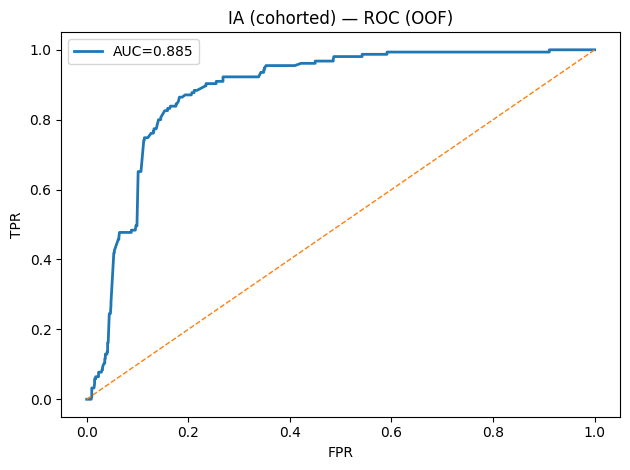

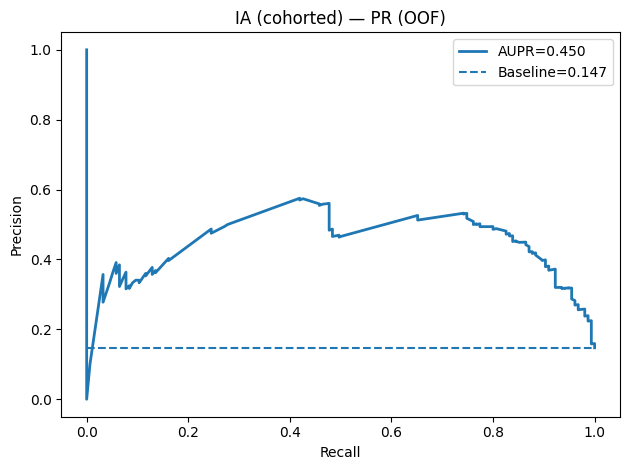

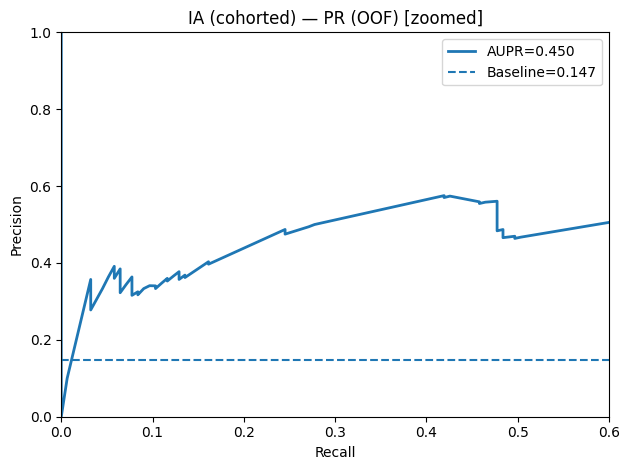

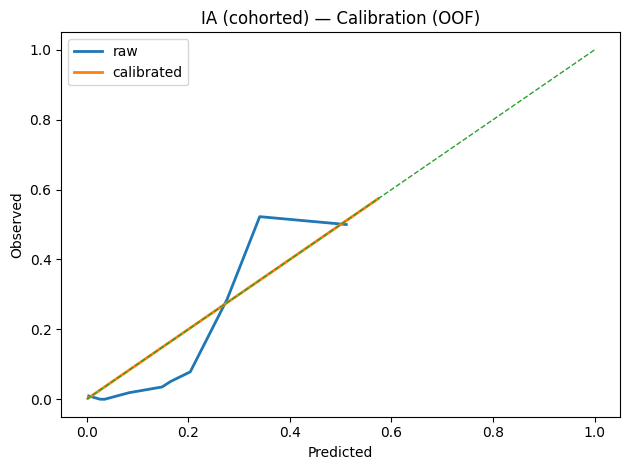

Saved reliability_table.csv


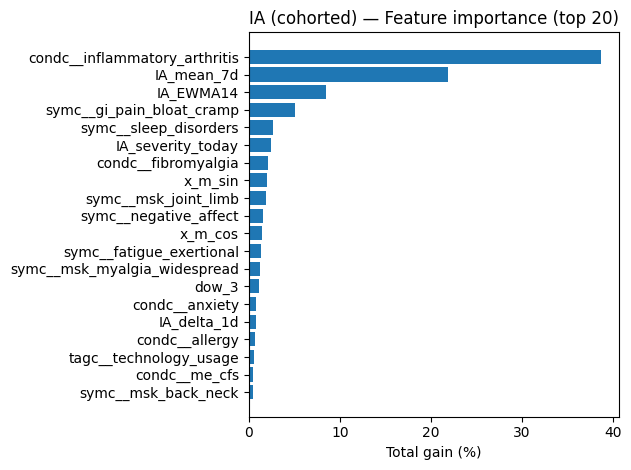

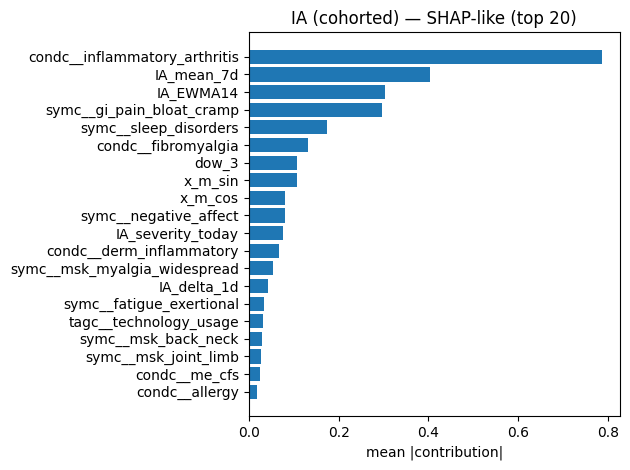

In [ ]:
# Producing figures and reliability table (counts per bin)

from sklearn.metrics import roc_curve, precision_recall_curve, auc
Path("figs_ia_cohorted").mkdir(exist_ok=True)

# ROC
fpr, tpr, _ = roc_curve(y, cv_all["oof"])
roc_auc = auc(fpr, tpr)
plt.figure(); plt.plot(fpr, tpr, linewidth=2, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],"--", linewidth=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("IA (cohorted) — ROC (OOF)"); plt.legend()
plt.tight_layout(); plt.savefig("figs_ia_cohorted/roc.png", dpi=150); plt.show()

# PR (full) + baseline
prec, rec, _ = precision_recall_curve(y, cv_all["oof"])
pr_auc = auc(rec, prec); base = y.mean()
plt.figure(); plt.plot(rec, prec, linewidth=2, label=f"AUPR={pr_auc:.3f}")
plt.hlines(base, 0, 1, linestyles="--", label=f"Baseline={base:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("IA (cohorted) — PR (OOF)"); plt.legend()
plt.tight_layout(); plt.savefig("figs_ia_cohorted/pr.png", dpi=150); plt.show()

# PR (zoom to the action range)
plt.figure(); plt.plot(rec, prec, linewidth=2, label=f"AUPR={pr_auc:.3f}")
plt.hlines(base, 0, 1, linestyles="--", label=f"Baseline={base:.3f}")
plt.xlim(0, 0.6); plt.ylim(0, 1.0)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("IA (cohorted) — PR (OOF) [zoomed]")
plt.legend(); plt.tight_layout(); plt.savefig("figs_ia_cohorted/pr_zoom.png", dpi=150); plt.show()

# Calibration (raw vs isotonic)
pt_raw, pp_raw = calibration_curve(y, cv_all["oof"], n_bins=10, strategy="quantile")
pt_cal, pp_cal = calibration_curve(y, cv_all["oof_cal"], n_bins=10, strategy="quantile")
plt.figure()
plt.plot(pp_raw, pt_raw, linewidth=2, label="raw")
plt.plot(pp_cal, pt_cal, linewidth=2, label="calibrated")
plt.plot([0,1],[0,1], "--", linewidth=1)
plt.xlabel("Predicted"); plt.ylabel("Observed"); plt.title("IA (cohorted) — Calibration (OOF)")
plt.legend(); plt.tight_layout(); plt.savefig("figs_ia_cohorted/calibration.png", dpi=150); plt.show()

# Reliability table with counts per bin (use calibrated scores)
bins = np.quantile(cv_all["oof_cal"], np.linspace(0,1,11))
b = np.digitize(cv_all["oof_cal"], bins[1:-1], right=True)
reliability = pd.DataFrame({
    "bin": np.arange(10),
    "n":   [np.sum(b==i) for i in range(10)],
    "pred_mean": [cv_all["oof_cal"][b==i].mean() if (b==i).any() else np.nan for i in range(10)],
    "obs_rate":  [y[b==i].mean() if (b==i).any() else np.nan for i in range(10)],
})
reliability.to_csv("figs_ia_cohorted/reliability_table.csv", index=False)
print("Saved reliability_table.csv")

# Importance (gain) for quick visual context
gain = cv_all["gain"]; gain_norm = 100*gain/(gain.sum() if gain.sum()>0 else 1.0)
plt.figure(); order = gain_norm.sort_values(ascending=True).head(20)  # 20 smallest -> barh asc
order = gain_norm.sort_values(ascending=True)  # full sorted
top20 = order.tail(20)                          # top-20 largest
plt.barh(top20.index, top20.values)
plt.xlabel("Total gain (%)"); plt.title("IA (cohorted) — Feature importance (top 20)")
plt.tight_layout(); plt.savefig("figs_ia_cohorted/importance_top20.png", dpi=150); plt.show()

# SHAP-like contributions on best fold
contrib = best_model.booster_.predict(X_all, num_iteration=best_iter, pred_contrib=True)
mac = np.abs(np.asarray(contrib)[:, :-1]).mean(axis=0)
shap_like_all = pd.Series(mac, index=X_all.columns).sort_values(ascending=True)
plt.figure(); top20s = shap_like_all.tail(20)
plt.barh(top20s.index, top20s.values)
plt.xlabel("mean |contribution|"); plt.title("IA (cohorted) — SHAP-like (top 20)")
plt.tight_layout(); plt.savefig("figs_ia_cohorted/shap_like_top20.png", dpi=150); plt.show()


### Feature Picking

In [ ]:
# Define compact IA feature sets (6, 8, 10, 12 features) based on cohorted rankings/plots.

def present(cols, in_df):
    return [c for c in cols if c in in_df.columns]

# Core MSK feature with fallbacks
def choose_msk(D):
    for c in ["symc__msk_joint_limb", "symc__msk_myalgia_widespread", "symc__msk_back_neck"]:
        if c in D.columns: return c
    return None

# GI feature
def choose_gi(D):
    for c in ["symc__gi_pain_bloat_cramp", "symc__gi_upper_reflux"]:
        if c in D.columns: return c
    return None

MSK = choose_msk(D)
GI  = choose_gi(D)

CORE6 = [  # very lean, biology-centric
    "IA_mean_7d", "IA_EWMA14", "IA_severity_today",
    "condc__inflammatory_arthritis",   # condition slider adds signal beyond union severity
    MSK,                                # fallback handled above
    "symc__sleep_disorders",
]
CORE6 = [c for c in CORE6 if c is not None]

SET_6  = CORE6
SET_8  = CORE6 + [GI, "x_m_cos"]
SET_10 = SET_8 + ["symc__negative_affect", "IA_delta_1d"]
SET_12 = SET_10 + ["x_m_sin", "condc__fibromyalgia"]

# de-duplicate and keep only columns that exist
def sanitize(s, D):
    seen = set(); out = []
    for c in s:
        if c is None or c not in D.columns: continue
        if c in seen: continue
        seen.add(c); out.append(c)
    return out

FEATURE_SETS = {
    "IA_6":  sanitize(SET_6,  D),
    "IA_8":  sanitize(SET_8,  D),
    "IA_10": sanitize(SET_10, D),
    "IA_12": sanitize(SET_12, D),
}

for name, feats in FEATURE_SETS.items():
    print(f"{name}  ({len(feats)} feats): {feats}")

IA_6  (6 feats): ['IA_mean_7d', 'IA_EWMA14', 'IA_severity_today', 'condc__inflammatory_arthritis', 'symc__msk_joint_limb', 'symc__sleep_disorders']
IA_8  (8 feats): ['IA_mean_7d', 'IA_EWMA14', 'IA_severity_today', 'condc__inflammatory_arthritis', 'symc__msk_joint_limb', 'symc__sleep_disorders', 'symc__gi_pain_bloat_cramp', 'x_m_cos']
IA_10  (10 feats): ['IA_mean_7d', 'IA_EWMA14', 'IA_severity_today', 'condc__inflammatory_arthritis', 'symc__msk_joint_limb', 'symc__sleep_disorders', 'symc__gi_pain_bloat_cramp', 'x_m_cos', 'symc__negative_affect', 'IA_delta_1d']
IA_12  (12 feats): ['IA_mean_7d', 'IA_EWMA14', 'IA_severity_today', 'condc__inflammatory_arthritis', 'symc__msk_joint_limb', 'symc__sleep_disorders', 'symc__gi_pain_bloat_cramp', 'x_m_cos', 'symc__negative_affect', 'IA_delta_1d', 'x_m_sin', 'condc__fibromyalgia']



=== IA_6 | #features=6 ===
[Fold 1] AUC=0.978  AUPR=0.250  best_iter=60
[Fold 2] AUC=0.941  AUPR=0.505  best_iter=89
[Fold 3] AUC=0.845  AUPR=0.617  best_iter=26
[Fold 4] AUC=0.765  AUPR=0.156  best_iter=20
[Fold 5] AUC=0.862  AUPR=0.740  best_iter=30
OOF: AUROC=0.902  AUPR=0.575 (baseline=0.147, lift=3.9x)  Brier=0.097  CalBrier=0.074  BSS=0.22

=== IA_8 | #features=8 ===
[Fold 1] AUC=0.977  AUPR=0.225  best_iter=30
[Fold 2] AUC=0.935  AUPR=0.507  best_iter=50
[Fold 3] AUC=0.840  AUPR=0.606  best_iter=10
[Fold 4] AUC=0.798  AUPR=0.167  best_iter=20
[Fold 5] AUC=0.865  AUPR=0.728  best_iter=4
OOF: AUROC=0.812  AUPR=0.357 (baseline=0.147, lift=2.4x)  Brier=0.113  CalBrier=0.100  BSS=0.10

=== IA_10 | #features=10 ===
[Fold 1] AUC=0.978  AUPR=0.250  best_iter=16
[Fold 2] AUC=0.938  AUPR=0.511  best_iter=94
[Fold 3] AUC=0.840  AUPR=0.635  best_iter=2
[Fold 4] AUC=0.805  AUPR=0.174  best_iter=122
[Fold 5] AUC=0.879  AUPR=0.733  best_iter=4
OOF: AUROC=0.802  AUPR=0.342 (baseline=0.147, lif

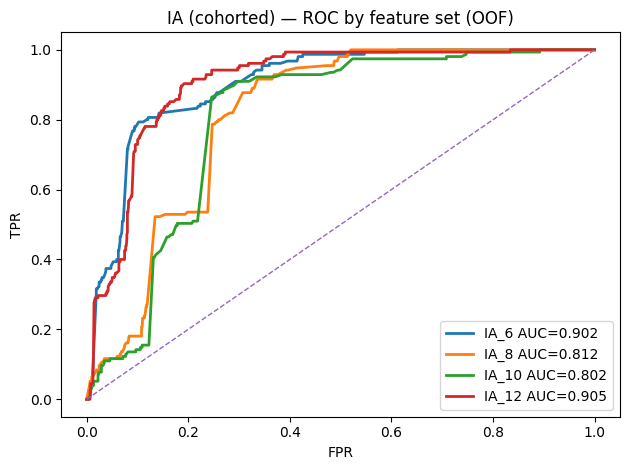

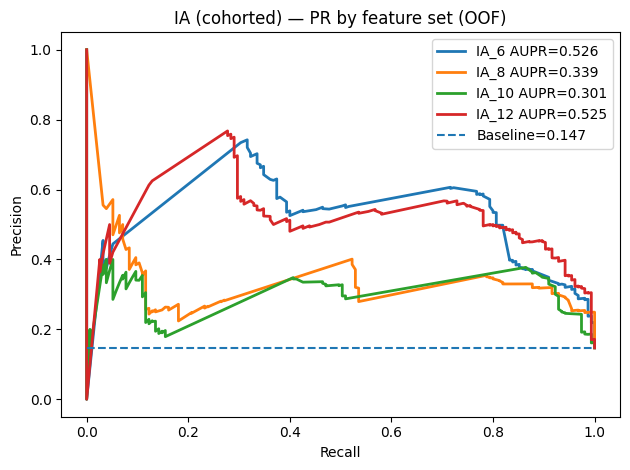


Selected set: IA_6 (6 feats)
['IA_mean_7d', 'IA_EWMA14', 'IA_severity_today', 'condc__inflammatory_arthritis', 'symc__msk_joint_limb', 'symc__sleep_disorders']


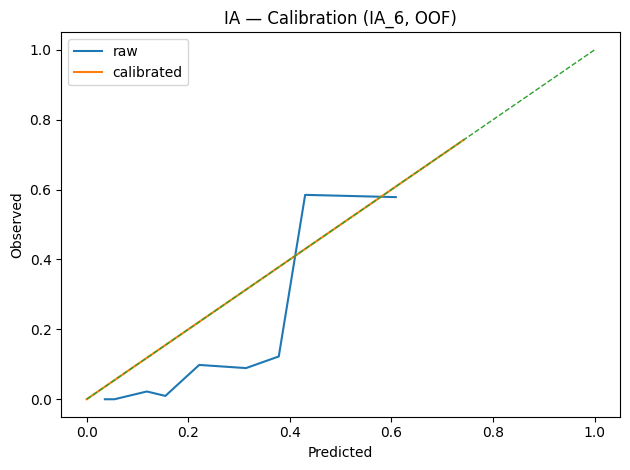

Saved: figs_ia_final/reliability_table_best.csv


In [ ]:
# Group-aware LightGBM for each set; isotonic calibration; metrics table; overlay ROC/PR; reliability.

import numpy as np, pandas as pd, matplotlib.pyplot as plt, json, gc, os
from pathlib import Path
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    roc_curve, precision_recall_curve, auc, confusion_matrix
)

Path("figs_ia_final").mkdir(exist_ok=True)

def run_lgbm_groupcv(X, y, groups, n_splits=5, seed=42):
    gkf = GroupKFold(n_splits=n_splits)
    oof = np.zeros(len(y), dtype=float)
    models, iters, folds = [], [], []
    for k, (tr, va) in enumerate(gkf.split(X, y, groups), 1):
        Xtr, ytr = X.iloc[tr], y[tr]
        Xva, yva = X.iloc[va], y[va]
        pos, neg = ytr.sum(), len(ytr)-ytr.sum()
        spw = (neg / max(pos,1))

        params = dict(
            objective="binary", metric="auc",
            learning_rate=0.03, num_leaves=255,
            min_data_in_leaf=60, feature_fraction=0.9, bagging_fraction=0.9, bagging_freq=1,
            lambda_l2=1.0, max_depth=-1, n_jobs=-1, random_state=seed,
            scale_pos_weight=spw, verbose=-1
        )
        clf = lgb.LGBMClassifier(**params, n_estimators=2000)
        clf.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)], eval_metric="auc",
            callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
        )
        bi = clf.best_iteration_ or 2000
        models.append(clf); iters.append(bi); folds.append((tr,va))
        oof[va] = clf.predict_proba(Xva, num_iteration=bi)[:,1]
        print(f"[Fold {k}] AUC={roc_auc_score(yva,oof[va]):.3f}  AUPR={average_precision_score(yva,oof[va]):.3f}  best_iter={bi}")

    # OOF metrics
    auroc = roc_auc_score(y, oof)
    aupr  = average_precision_score(y, oof)
    brier = brier_score_loss(y, oof)

    # Calibration
    ir = IsotonicRegression(out_of_bounds="clip").fit(oof, y)
    oof_cal = ir.predict(oof)
    brier_cal = brier_score_loss(y, oof_cal)

    return dict(oof=oof, oof_cal=oof_cal, models=models, iters=np.array(iters),
                folds=folds, auroc=auroc, aupr=aupr, brier=brier, brier_cal=brier_cal, calibrator=ir)

results = {}
for name, feats in FEATURE_SETS.items():
    X = D[feats].apply(pd.to_numeric, errors="coerce").astype("float32").fillna(0.0)
    print(f"\n=== {name} | #features={X.shape[1]} ===")
    res = run_lgbm_groupcv(X, y, groups, n_splits=5, seed=42)
    results[name] = (feats, X, res)
    prev = y.mean(); lift = res["aupr"]/prev; brier_climo = prev*(1-prev); bss = 1 - res["brier"]/brier_climo
    print(f"OOF: AUROC={res['auroc']:.3f}  AUPR={res['aupr']:.3f} (baseline={prev:.3f}, lift={lift:.1f}x)  "
          f"Brier={res['brier']:.3f}  CalBrier={res['brier_cal']:.3f}  BSS={bss:.2f}")

# Overlay ROC/PR for all sets
plt.figure()
for name,(feats,X,res) in results.items():
    fpr, tpr, _ = roc_curve(y, res["oof"])
    plt.plot(fpr, tpr, lw=2, label=f"{name} AUC={auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],"--", lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("IA (cohorted) — ROC by feature set (OOF)")
plt.legend(); plt.tight_layout(); plt.savefig("figs_ia_final/roc_overlaid.png", dpi=150); plt.show()

plt.figure()
for name,(feats,X,res) in results.items():
    pr, rc, _ = precision_recall_curve(y, res["oof"])
    plt.plot(rc, pr, lw=2, label=f"{name} AUPR={auc(rc,pr):.3f}")
plt.hlines(y.mean(), 0, 1, linestyles="--", label=f"Baseline={y.mean():.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("IA (cohorted) — PR by feature set (OOF)")
plt.legend(); plt.tight_layout(); plt.savefig("figs_ia_final/pr_overlaid.png", dpi=150); plt.show()

# Pick the best set by AUPR
best_name = max(results.keys(), key=lambda k: results[k][2]["aupr"])
best_feats, best_X, best_res = results[best_name]
print(f"\nSelected set: {best_name} ({len(best_feats)} feats)\n{best_feats}")

# Calibration plot and reliability table for the best set
from sklearn.calibration import calibration_curve
pt_raw, pp_raw = calibration_curve(y, best_res["oof"], n_bins=10, strategy="quantile")
pt_cal, pp_cal = calibration_curve(y, best_res["oof_cal"], n_bins=10, strategy="quantile")
plt.figure()
plt.plot(pp_raw, pt_raw, label="raw"); plt.plot(pp_cal, pt_cal, label="calibrated")
plt.plot([0,1],[0,1],"--", lw=1); plt.xlabel("Predicted"); plt.ylabel("Observed")
plt.title(f"IA — Calibration ({best_name}, OOF)"); plt.legend(); plt.tight_layout()
plt.savefig("figs_ia_final/calibration_best.png", dpi=150); plt.show()

bins = np.quantile(best_res["oof_cal"], np.linspace(0,1,11))
b = np.digitize(best_res["oof_cal"], bins[1:-1], right=True)
reliability = pd.DataFrame({
    "bin": np.arange(10),
    "n":   [np.sum(b==i) for i in range(10)],
    "pred_mean": [best_res["oof_cal"][b==i].mean() if (b==i).any() else np.nan for i in range(10)],
    "obs_rate":  [y[b==i].mean() if (b==i).any() else np.nan for i in range(10)],
})
reliability.to_csv("figs_ia_final/reliability_table_best.csv", index=False)
print("Saved: figs_ia_final/reliability_table_best.csv")

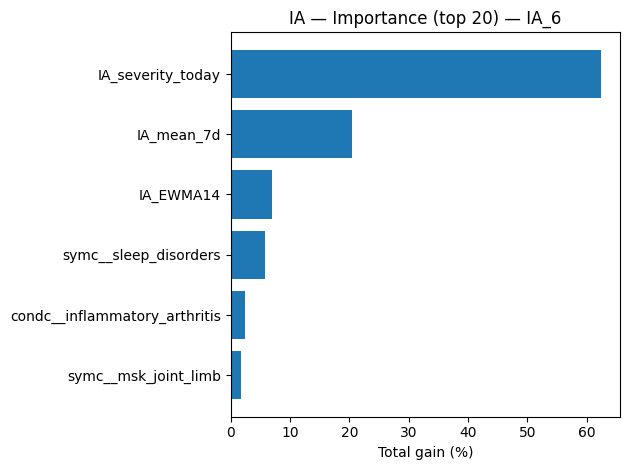

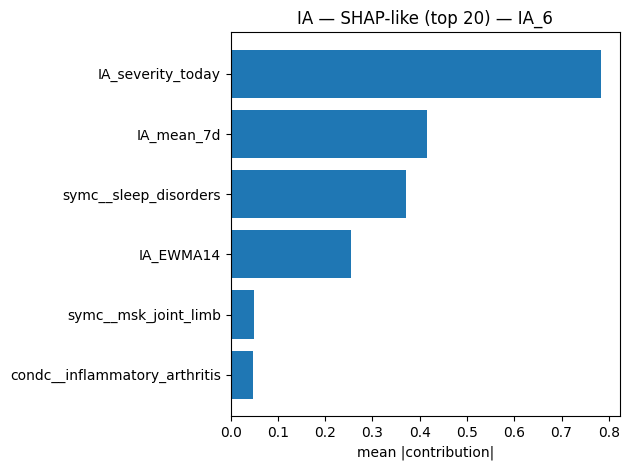

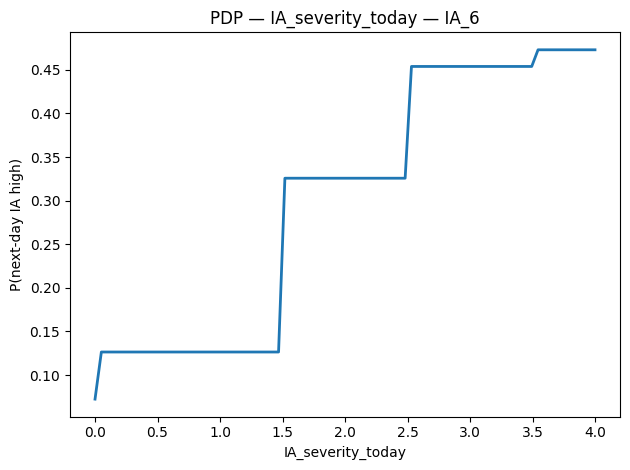

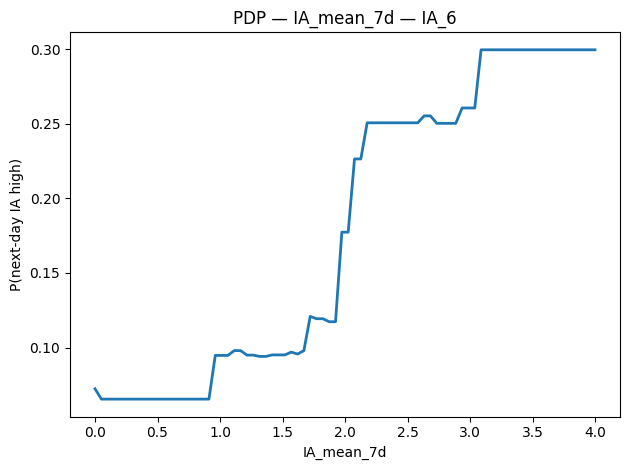

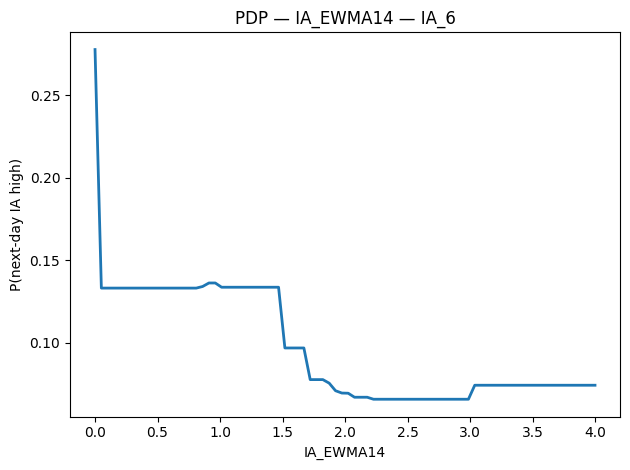

Youden-J: t=0.222 | Sens=0.794 Spec=0.898 Prec=0.572 | TP=123 FP=92 FN=32 TN=806
Max-F1: t=0.467 | Sens=0.768 Spec=0.910 Prec=0.595 | TP=119 FP=81 FN=36 TN=817
Prec≥0.50: t=0.103 | Sens=0.955 Spec=0.655 Prec=0.323 | TP=148 FP=310 FN=7 TN=588


In [ ]:
# Importance, SHAP-like bars, PDPs for top 3 features, and threshold summaries for the best set.

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, f1_score
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import lightgbm as lgb

# Choose the best fold by AUC to compute SHAP-like values
best_idx = int(np.argmax([
    roc_auc_score(y[va], m.predict_proba(best_X.iloc[va], num_iteration=it)[:,1])
    for (tr,va), m, it in zip(best_res["folds"], best_res["models"], best_res["iters"])
]))
best_model = best_res["models"][best_idx]; best_iter = int(best_res["iters"][best_idx])

# Gain importance
gain = pd.Series(best_model.booster_.feature_importance(importance_type="gain", iteration=best_iter),
                 index=best_X.columns)
gain = 100 * gain / (gain.sum() if gain.sum() > 0 else 1.0)
order = gain.sort_values(ascending=True).tail(20)
plt.figure(); plt.barh(order.index, order.values)
plt.xlabel("Total gain (%)"); plt.title(f"IA — Importance (top 20) — {best_name}")
plt.tight_layout(); plt.savefig("figs_ia_final/importance_top20_best.png", dpi=150); plt.show()

# SHAP-like contributions using pred_contrib=True (last column is bias term)
contrib = best_model.booster_.predict(best_X, num_iteration=best_iter, pred_contrib=True)
mac = np.abs(np.asarray(contrib)[:, :-1]).mean(axis=0)
shap_like = pd.Series(mac, index=best_X.columns).sort_values(ascending=True).tail(20)
plt.figure(); plt.barh(shap_like.index, shap_like.values)
plt.xlabel("mean |contribution|"); plt.title(f"IA — SHAP-like (top 20) — {best_name}")
plt.tight_layout(); plt.savefig("figs_ia_final/shap_like_top20_best.png", dpi=150); plt.show()

# PDPs for top 3 features by gain
def pdp_1d(model, X, feat, it, n=80):
    x = X[feat]; grid = np.linspace(np.nanpercentile(x,1), np.nanpercentile(x,99), n)
    med = X.median(numeric_only=True)
    preds = []
    for v in grid:
        r = med.copy(); r[feat]=v
        preds.append(model.predict_proba(pd.DataFrame([r], columns=X.columns), num_iteration=it)[:,1][0])
    plt.figure(); plt.plot(grid, preds, lw=2)
    plt.xlabel(feat); plt.ylabel("P(next-day IA high)")
    plt.title(f"PDP — {feat} — {best_name}")
    plt.tight_layout(); plt.savefig(f"figs_ia_final/pdp_{feat}_{best_name}.png", dpi=150); plt.show()

top3 = gain.sort_values(ascending=False).head(3).index.tolist()
for f in top3: pdp_1d(best_model, best_X, f, best_iter)

# Thresholds: Youden-J, max-F1, and "recall at 50% precision"
from sklearn.metrics import confusion_matrix

def print_confusion(y_true, p_cal, t, label):
    yh = (p_cal >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yh).ravel()
    sens = tp/(tp+fn+1e-9); spec = tn/(tn+fp+1e-9); prec = tp/(tp+fp+1e-9)
    print(f"{label}: t={t:.3f} | Sens={sens:.3f} Spec={spec:.3f} Prec={prec:.3f} | TP={tp} FP={fp} FN={fn} TN={tn}")

# Calibrated probabilities
p_cal = best_res["oof_cal"]

fpr, tpr, thr = roc_curve(y, p_cal); j = tpr - fpr; t_j = thr[np.argmax(j)]
pr, rc, thr_pr = precision_recall_curve(y, p_cal); f1 = 2*pr*rc/(pr+rc+1e-9); t_f1 = thr_pr[np.argmax(f1[:-1])]

# precision>=0.50 threshold (conservative alerting)
order = np.argsort(-p_cal); cum_tp = np.cumsum(y[order]); cum_fp = np.cumsum(1 - y[order])
precision_curve = cum_tp / (cum_tp + cum_fp + 1e-9)
idx = np.where(precision_curve >= 0.50)[0]
t_p50 = p_cal[order[idx[-1]]] if idx.size>0 else 1.0

print_confusion(y, p_cal, t_j,   "Youden-J")
print_confusion(y, p_cal, t_f1,  "Max-F1")
print_confusion(y, p_cal, t_p50, "Prec≥0.50")

In [ ]:
# Fit the best feature set on ALL rows; save booster, calibrator, and a simple model card.

import joblib, json
Path("models_ia_final").mkdir(exist_ok=True)

# Average best-iterations across CV folds for a reasonable n_estimators
final_rounds = int(np.clip(np.round(best_res["iters"].mean()), 100, 2000))
pos = y.sum(); neg = len(y)-y.sum(); spw = (neg/max(pos,1))

params = dict(objective="binary", learning_rate=0.03, num_leaves=255,
              min_data_in_leaf=60, feature_fraction=0.9, bagging_fraction=0.9, bagging_freq=1,
              lambda_l2=1.0, max_depth=-1, n_jobs=-1, random_state=42,
              scale_pos_weight=spw, verbose=-1)
final = lgb.LGBMClassifier(**params, n_estimators=final_rounds).fit(best_X, y)

final.booster_.save_model(f"models_ia_final/ia_lgbm_{best_name}.txt")
joblib.dump(best_res["calibrator"], f"models_ia_final/ia_isotonic_{best_name}.joblib")
with open(f"models_ia_final/ia_features_{best_name}.json","w") as f:
    json.dump({
        "feature_names": list(best_X.columns),
        "num_boost_round": final_rounds,
        "cohort_rule": "any_IA_ge1",
        "label": "next-day inflammatory arthritis high (>=3)",
        "training_rows": int(len(D)),
        "training_users": int(D['user_id'].nunique()),
        "oof": {
            "auroc": float(best_res["auroc"]),
            "aupr":  float(best_res["aupr"]),
            "baseline_prevalence": float(y.mean()),
            "brier": float(best_res["brier"]),
            "brier_calibrated": float(best_res["brier_cal"])
        }
    }, f, indent=2)

print(f"Saved:\n  models_ia_final/ia_lgbm_{best_name}.txt\n  models_ia_final/ia_isotonic_{best_name}.joblib\n  models_ia_final/ia_features_{best_name}.json")

Saved:
  models_ia_final/ia_lgbm_IA_6.txt
  models_ia_final/ia_isotonic_IA_6.joblib
  models_ia_final/ia_features_IA_6.json


### Final Model (12 features)

IA_12 features (12): ['IA_mean_7d', 'IA_EWMA14', 'IA_severity_today', 'condc__inflammatory_arthritis', 'symc__msk_joint_limb', 'symc__sleep_disorders', 'symc__gi_pain_bloat_cramp', 'x_m_cos', 'symc__negative_affect', 'IA_delta_1d', 'x_m_sin', 'condc__fibromyalgia']
[Fold 1] AUC=0.978  AUPR=0.250  best_iter=68
[Fold 2] AUC=0.948  AUPR=0.630  best_iter=121
[Fold 3] AUC=0.856  AUPR=0.624  best_iter=35
[Fold 4] AUC=0.830  AUPR=0.161  best_iter=217
[Fold 5] AUC=0.872  AUPR=0.683  best_iter=96

[IA_12 OOF]
  AUROC = 0.905
  AUPR  = 0.552  (baseline=0.147, lift=3.7x)
  Brier = 0.097  |  Calibrated Brier = 0.076  |  BSS=0.23


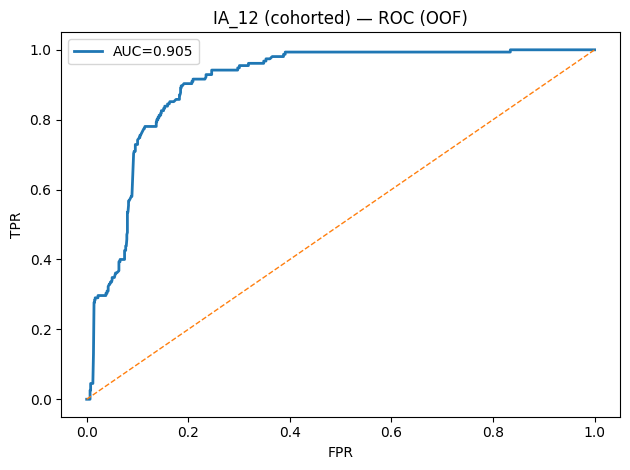

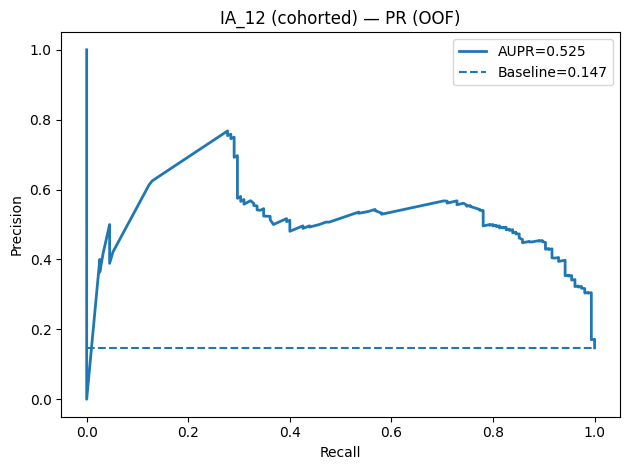

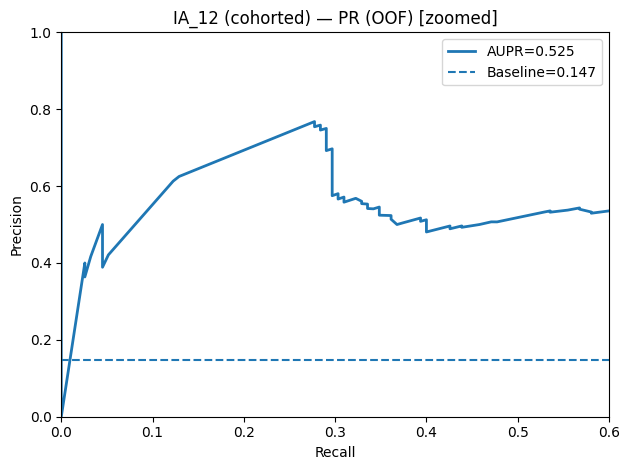

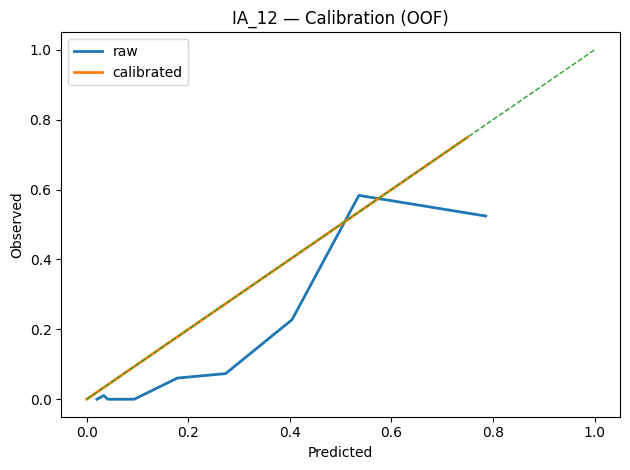

Saved: figs_ia12_final/reliability_table.csv


In [ ]:
# Build the IA_12 feature list (robust to missing columns), run GroupKFold CV,
# calibrate with isotonic regression, and print/plot core metrics.

import numpy as np, pandas as pd, matplotlib.pyplot as plt, json, gc, os
from pathlib import Path
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    roc_curve, precision_recall_curve, auc
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
Path("figs_ia12_final").mkdir(exist_ok=True)

# 1) Define IA_12
def choose_msk(D):
    for c in ["symc__msk_joint_limb", "symc__msk_myalgia_widespread", "symc__msk_back_neck"]:
        if c in D.columns: return c
    return None

def choose_gi(D):
    for c in ["symc__gi_pain_bloat_cramp", "symc__gi_upper_reflux"]:
        if c in D.columns: return c
    return None

MSK = choose_msk(D)
GI  = choose_gi(D)

IA_12 = [
    "IA_mean_7d", "IA_EWMA14", "IA_severity_today",
    "condc__inflammatory_arthritis",
    MSK, "symc__sleep_disorders",
    GI, "x_m_cos",
    "symc__negative_affect", "IA_delta_1d",
    "x_m_sin", "condc__fibromyalgia"
]
IA_12 = [c for c in IA_12 if c is not None and c in D.columns]  # sanitize

print(f"IA_12 features ({len(IA_12)}): {IA_12}")

# Candidate matrix (float32, fill NAs with 0)
X12 = D[IA_12].apply(pd.to_numeric, errors="coerce").astype("float32").fillna(0.0)

# Group-aware LightGBM CV with isotonic calibration
def run_lgbm_groupcv(X, y, groups, n_splits=5, seed=42):
    gkf = GroupKFold(n_splits=n_splits)
    oof = np.zeros(len(y), dtype=float)
    models, iters, folds = [], [], []

    for k, (tr, va) in enumerate(gkf.split(X, y, groups), 1):
        Xtr, ytr = X.iloc[tr], y[tr]
        Xva, yva = X.iloc[va], y[va]
        pos, neg = ytr.sum(), len(ytr)-ytr.sum()
        spw = (neg / max(pos,1))  # class balance

        params = dict(
            objective="binary", metric="auc",
            learning_rate=0.03, num_leaves=255,
            min_data_in_leaf=60, feature_fraction=0.9,
            bagging_fraction=0.9, bagging_freq=1,
            lambda_l2=1.0, max_depth=-1, n_jobs=-1,
            random_state=seed, scale_pos_weight=spw, verbose=-1
        )
        clf = lgb.LGBMClassifier(**params, n_estimators=2000)
        clf.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)], eval_metric="auc",
            callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
        )
        bi = clf.best_iteration_ or 2000
        models.append(clf); iters.append(bi); folds.append((tr,va))
        p = clf.predict_proba(Xva, num_iteration=bi)[:,1]
        oof[va] = p
        print(f"[Fold {k}] AUC={roc_auc_score(yva,p):.3f}  AUPR={average_precision_score(yva,p):.3f}  best_iter={bi}")

    # OOF metrics
    auroc = roc_auc_score(y, oof)
    aupr  = average_precision_score(y, oof)
    brier = brier_score_loss(y, oof)

    # Isotonic calibration (fit on OOF to avoid optimism)
    ir = IsotonicRegression(out_of_bounds="clip").fit(oof, y)
    oof_cal = ir.predict(oof)
    brier_cal = brier_score_loss(y, oof_cal)

    return dict(
        oof=oof, oof_cal=oof_cal, models=models, iters=np.array(iters),
        folds=folds, auroc=auroc, aupr=aupr, brier=brier, brier_cal=brier_cal, calibrator=ir
    )

cv12 = run_lgbm_groupcv(X12, y, groups, n_splits=5, seed=RANDOM_STATE)

# Print headline metrics and plot ROC/PR/Calibration
prev = y.mean(); lift = cv12["aupr"]/prev; brier_climo = prev*(1-prev)
bss = 1 - cv12["brier"]/brier_climo

print("\n[IA_12 OOF]")
print(f"  AUROC = {cv12['auroc']:.3f}")
print(f"  AUPR  = {cv12['aupr']:.3f}  (baseline={prev:.3f}, lift={lift:.1f}x)")
print(f"  Brier = {cv12['brier']:.3f}  |  Calibrated Brier = {cv12['brier_cal']:.3f}  |  BSS={bss:.2f}")

# ROC
fpr, tpr, _ = roc_curve(y, cv12["oof"])
plt.figure(); plt.plot(fpr, tpr, lw=2, label=f"AUC={auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],"--", lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("IA_12 (cohorted) — ROC (OOF)"); plt.legend()
plt.tight_layout(); plt.savefig("figs_ia12_final/roc.png", dpi=150); plt.show()

# PR
pr, rc, _ = precision_recall_curve(y, cv12["oof"])
plt.figure(); plt.plot(rc, pr, lw=2, label=f"AUPR={auc(rc,pr):.3f}")
plt.hlines(prev, 0, 1, linestyles="--", label=f"Baseline={prev:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("IA_12 (cohorted) — PR (OOF)"); plt.legend()
plt.tight_layout(); plt.savefig("figs_ia12_final/pr.png", dpi=150); plt.show()

# PR zoom
plt.figure(); plt.plot(rc, pr, lw=2, label=f"AUPR={auc(rc,pr):.3f}")
plt.hlines(prev, 0, 1, linestyles="--", label=f"Baseline={prev:.3f}")
plt.xlim(0, 0.6); plt.ylim(0, 1.0)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("IA_12 (cohorted) — PR (OOF) [zoomed]"); plt.legend()
plt.tight_layout(); plt.savefig("figs_ia12_final/pr_zoom.png", dpi=150); plt.show()

# Calibration (raw vs calibrated)
pt_raw, pp_raw = calibration_curve(y, cv12["oof"], n_bins=10, strategy="quantile")
pt_cal, pp_cal = calibration_curve(y, cv12["oof_cal"], n_bins=10, strategy="quantile")
plt.figure(); plt.plot(pp_raw, pt_raw, lw=2, label="raw")
plt.plot(pp_cal, pt_cal, lw=2, label="calibrated"); plt.plot([0,1],[0,1],"--", lw=1)
plt.xlabel("Predicted"); plt.ylabel("Observed"); plt.title("IA_12 — Calibration (OOF)")
plt.legend(); plt.tight_layout(); plt.savefig("figs_ia12_final/calibration.png", dpi=150); plt.show()

# Reliability table (calibrated)
bins = np.quantile(cv12["oof_cal"], np.linspace(0,1,11))
b = np.digitize(cv12["oof_cal"], bins[1:-1], right=True)
reliability = pd.DataFrame({
    "bin": np.arange(10),
    "n":   [np.sum(b==i) for i in range(10)],
    "pred_mean": [cv12["oof_cal"][b==i].mean() if (b==i).any() else np.nan for i in range(10)],
    "obs_rate":  [y[b==i].mean() if (b==i).any() else np.nan for i in range(10)],
})
reliability.to_csv("figs_ia12_final/reliability_table.csv", index=False)
print("Saved: figs_ia12_final/reliability_table.csv")

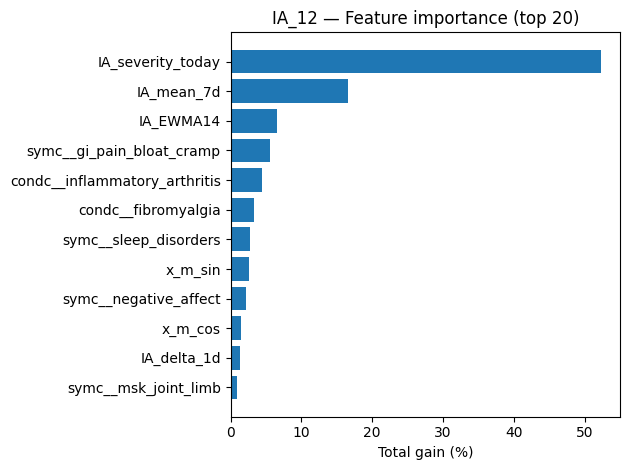

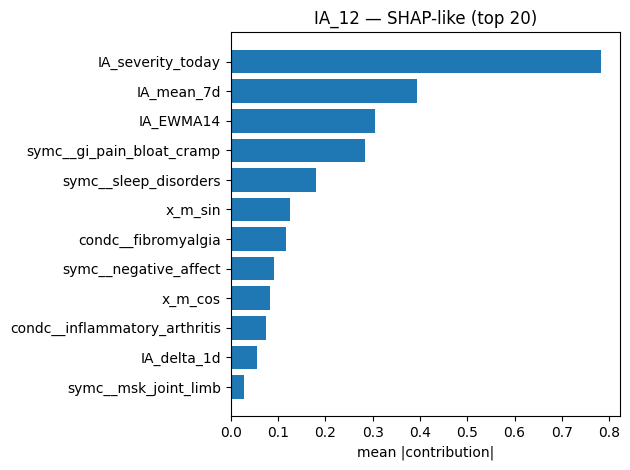

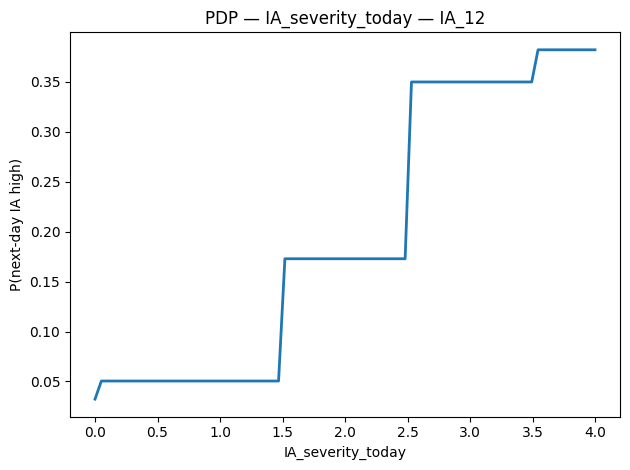

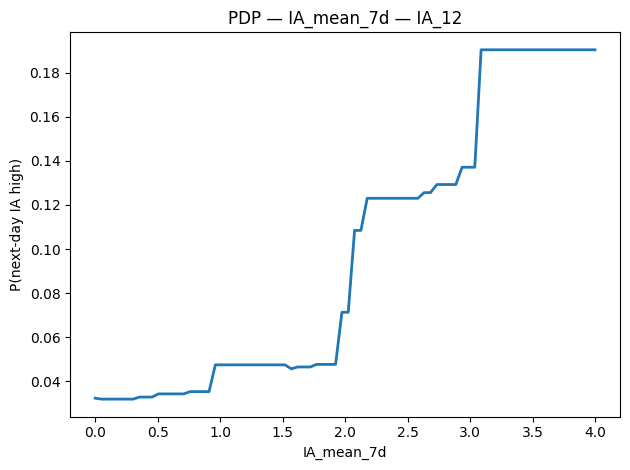

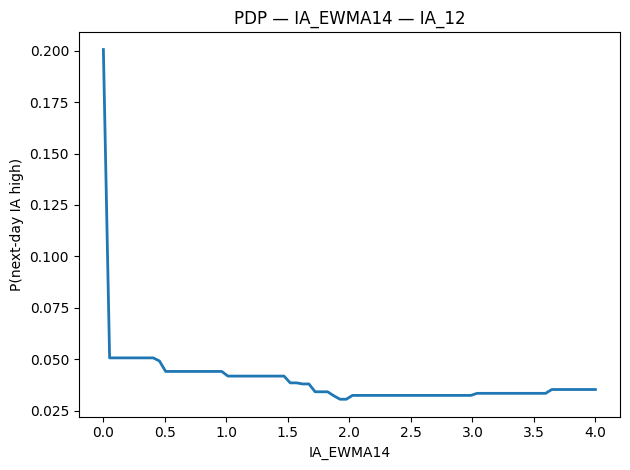

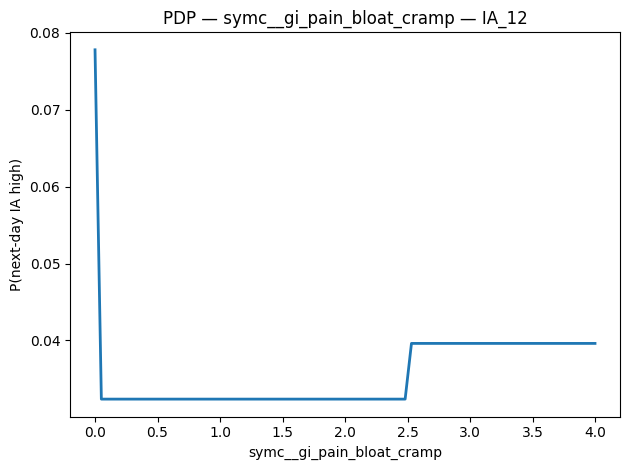

Saved: figs_ia12_final/thresholds_summary.csv


,threshold,precision,recall,specificity,f1,TP,FP,FN,TN
0,0.100000,0.397820,0.941935,0.753898,0.559387,146,221,9,677
5,0.166667,0.448718,0.903226,0.808463,0.599572,140,172,15,726
1,0.200000,0.454248,0.896774,0.814031,0.603037,139,167,16,731
2,0.300000,0.540179,0.780645,0.885301,0.638522,121,103,34,795
6,0.333333,0.554502,0.754839,0.895323,0.639344,117,94,38,804
3,0.400000,0.567839,0.729032,0.904232,0.638418,113,86,42,812
4,0.500000,0.750000,0.290323,0.983296,0.418605,45,15,110,883


In [ ]:
# Interpretability and operating thresholds for IA_12.

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score

# Choose best fold by AUC to compute SHAP-like values cleanly
best_idx = int(np.argmax([
    roc_auc_score(y[va], m.predict_proba(X12.iloc[va], num_iteration=it)[:,1])
    for (tr,va), m, it in zip(cv12["folds"], cv12["models"], cv12["iters"])
]))
best_model = cv12["models"][best_idx]; best_iter = int(cv12["iters"][best_idx])

# Gain importance
gain = pd.Series(best_model.booster_.feature_importance(importance_type="gain", iteration=best_iter),
                 index=X12.columns)
gain = 100 * gain / (gain.sum() if gain.sum() > 0 else 1.0)
top20_gain = gain.sort_values(ascending=True).tail(20)
plt.figure(); plt.barh(top20_gain.index, top20_gain.values)
plt.xlabel("Total gain (%)"); plt.title("IA_12 — Feature importance (top 20)")
plt.tight_layout(); plt.savefig("figs_ia12_final/importance_top20.png", dpi=150); plt.show()

# SHAP-like bars (pred_contrib=True)
contrib = best_model.booster_.predict(X12, num_iteration=best_iter, pred_contrib=True)
mac = np.abs(np.asarray(contrib)[:, :-1]).mean(axis=0)
shap_like = pd.Series(mac, index=X12.columns).sort_values(ascending=True).tail(20)
plt.figure(); plt.barh(shap_like.index, shap_like.values)
plt.xlabel("mean |contribution|"); plt.title("IA_12 — SHAP-like (top 20)")
plt.tight_layout(); plt.savefig("figs_ia12_final/shap_like_top20.png", dpi=150); plt.show()

# PDPs for the 4 strongest features by gain
def pdp_1d(model, X, feat, it, n=80):
    x = X[feat]; grid = np.linspace(np.nanpercentile(x,1), np.nanpercentile(x,99), n)
    med = X.median(numeric_only=True)
    preds = []
    for v in grid:
        r = med.copy(); r[feat]=v
        preds.append(model.predict_proba(pd.DataFrame([r], columns=X.columns), num_iteration=it)[:,1][0])
    plt.figure(); plt.plot(grid, preds, lw=2)
    plt.xlabel(feat); plt.ylabel("P(next-day IA high)")
    plt.title(f"PDP — {feat} — IA_12")
    plt.tight_layout(); plt.savefig(f"figs_ia12_final/pdp_{feat}.png", dpi=150); plt.show()

top4 = gain.sort_values(ascending=False).head(4).index.tolist()
for f in top4: pdp_1d(best_model, X12, f, best_iter)

# Threshold table (calibrated probabilities)
p_cal = cv12["oof_cal"]

def row_for(t):
    yh = (p_cal >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, yh).ravel()
    sens = tp/(tp+fn+1e-9); spec = tn/(tn+fp+1e-9); prec = tp/(tp+fp+1e-9)
    f1   = 2*prec*sens/(prec+sens+1e-9)
    return dict(threshold=t, precision=prec, recall=sens, specificity=spec, f1=f1, TP=tp, FP=fp, FN=fn, TN=tn)

# Youden-J and Max-F1
fpr, tpr, thr = roc_curve(y, p_cal); j = tpr - fpr; t_j = thr[np.argmax(j)]
pr, rc, thr_pr = precision_recall_curve(y, p_cal); f1 = 2*pr*rc/(pr+rc+1e-9); t_f1 = thr_pr[np.argmax(f1[:-1])]

# A few fixed thresholds for the UI
grid = [0.10, 0.20, 0.30, 0.40, 0.50, t_j, t_f1]
table = pd.DataFrame([row_for(t) for t in grid]).sort_values("threshold")
table.to_csv("figs_ia12_final/thresholds_summary.csv", index=False)
print("Saved: figs_ia12_final/thresholds_summary.csv")
display(table)

In [ ]:
# Fit the final LightGBM on all data with IA_12, save booster, saved calibrator (fit on OOF),
# and a simple model card with OOF metrics.

import joblib, json
Path("models_ia12_final").mkdir(exist_ok=True)

# Reasonable n_estimators: mean best iteration across folds (clamped 100..2000)
final_rounds = int(np.clip(np.round(cv12["iters"].mean()), 100, 2000))
pos = y.sum(); neg = len(y)-y.sum(); spw = (neg/max(pos,1))

params = dict(objective="binary", learning_rate=0.03, num_leaves=255,
              min_data_in_leaf=60, feature_fraction=0.9, bagging_fraction=0.9, bagging_freq=1,
              lambda_l2=1.0, max_depth=-1, n_jobs=-1, random_state=RANDOM_STATE,
              scale_pos_weight=spw, verbose=-1)

final12 = lgb.LGBMClassifier(**params, n_estimators=final_rounds).fit(X12, y)

# Save booster, calibrator (from OOF), and model card
final12.booster_.save_model("models_ia12_final/ia12_lgbm.txt")
joblib.dump(cv12["calibrator"], "models_ia12_final/ia12_isotonic.joblib")
with open("models_ia12_final/ia12_features.json","w") as f:
    json.dump({"feature_names": list(X12.columns)}, f, indent=2)

with open("models_ia12_final/ia12_model_card.json","w") as f:
    json.dump({
        "cohort_rule": "any_IA_ge1",
        "label": "next-day inflammatory arthritis high (>=3)",
        "training_rows": int(len(D)),
        "training_users": int(D['user_id'].nunique()),
        "feature_count": int(X12.shape[1]),
        "n_estimators": final_rounds,
        "oof": {
            "prevalence": float(y.mean()),
            "auroc": float(cv12["auroc"]),
            "aupr":  float(cv12["aupr"]),
            "brier": float(cv12["brier"]),
            "brier_calibrated": float(cv12["brier_cal"])
        }
    }, f, indent=2)

print("Saved:")
print("  models_ia12_final/ia12_lgbm.txt")
print("  models_ia12_final/ia12_isotonic.joblib")
print("  models_ia12_final/ia12_features.json")
print("  models_ia12_final/ia12_model_card.json")

Saved:
  models_ia12_final/ia12_lgbm.txt
  models_ia12_final/ia12_isotonic.joblib
  models_ia12_final/ia12_features.json
  models_ia12_final/ia12_model_card.json


### Inference vector

In [ ]:
# Loads the trained LightGBM booster + isotonic calibrator,
# takes a single-day feature vector (dict/Series/DataFrame),
# and returns calibrated probability + top contributing features.

import json, joblib, numpy as np, pandas as pd, lightgbm as lgb
from pathlib import Path
from typing import Union, Dict, List

class IA12Model:
    def __init__(self, model_dir: str = "models_ia12_final"):
        model_dir = Path(model_dir)
        # 1) feature order
        with open(model_dir / "ia12_features.json", "r") as f:
            self.feature_names: List[str] = json.load(f)["feature_names"]
        # 2) booster
        self.booster = lgb.Booster(model_file=str(model_dir / "ia12_lgbm.txt"))
        # 3) isotonic calibrator
        self.calibrator = joblib.load(model_dir / "ia12_isotonic.joblib")

        # Nice names for UI explanations
        self.nice = {
            "IA_mean_7d": "IA 7‑day average",
            "IA_EWMA14": "IA 14‑day trend (EWMA)",
            "IA_severity_today": "IA today",
            "condc__inflammatory_arthritis": "IA (condition slider)",
            "symc__msk_joint_limb": "Joint/limb pain",
            "symc__sleep_disorders": "Sleep problems",
            "symc__gi_pain_bloat_cramp": "GI pain/bloating",
            "x_m_cos": "Seasonality (cosine)",
            "symc__negative_affect": "Negative mood",
            "IA_delta_1d": "IA change vs yesterday",
            "x_m_sin": "Seasonality (sine)",
            "condc__fibromyalgia": "Fibromyalgia (condition)"
        }

    def _row_to_df(self, row: Union[Dict, pd.Series, pd.DataFrame]) -> pd.DataFrame:
        """Ensure a single-row DataFrame in the trained feature order; missing → 0.0"""
        if isinstance(row, dict):
            r = pd.DataFrame([row])
        elif isinstance(row, pd.Series):
            r = row.to_frame().T
        elif isinstance(row, pd.DataFrame):
            if len(row) != 1:
                raise ValueError("Provide exactly one row in the DataFrame.")
            r = row.copy()
        else:
            raise TypeError("row must be dict / Series / single-row DataFrame")

        # Keep only trained features, add any missing ones as 0.0
        for c in self.feature_names:
            if c not in r.columns:
                r[c] = 0.0
        r = r[self.feature_names]
        r = r.apply(pd.to_numeric, errors="coerce").astype("float32").fillna(0.0)
        return r

    def predict_one(self, row: Union[Dict, pd.Series, pd.DataFrame], top_k: int = 5):
        """Return calibrated probability and top-k contributors (TreeSHAP)."""
        X = self._row_to_df(row)

        # Raw probability
        p_raw = self.booster.predict(X.values, num_iteration=self.booster.current_iteration())[0]
        # Calibrated probability (isotonic)
        p_cal = float(self.calibrator.predict([p_raw])[0])

        # Contributions (TreeSHAP via LightGBM pred_contrib); last column is bias term
        contrib = self.booster.predict(X.values, pred_contrib=True)[0]
        bias = contrib[-1]
        per_feat = pd.Series(contrib[:-1], index=self.feature_names)

        # Rank by absolute contribution
        top = per_feat.reindex(self.feature_names).abs().sort_values(ascending=False).head(top_k).index.tolist()
        top_details = []
        for f in top:
            sign = "↑" if per_feat[f] > 0 else "↓"
            display = self.nice.get(f, f)
            top_details.append({
                "feature": f,
                "display_name": display,
                "direction": sign,               # ↑ increased risk, ↓ decreased risk
                "contribution": float(per_feat[f]),
                "value": float(X.iloc[0][f])
            })

        # risk bands (based on OOF analysis for IA_12)
        t_elev, t_high = 0.22, 0.47
        if p_cal >= t_high:
            band = "high"
        elif p_cal >= t_elev:
            band = "elevated"
        else:
            band = "low"

        return {
            "p_raw": float(p_raw),
            "p_cal": p_cal,
            "risk_band": band,
            "top_contributors": top_details,
            "bias": float(bias)
        }

# Example usage
# mdl = IA12Model("models_ia12_final")
# # Suppose 'D_today' is a one-row dataframe or can also construct a dict with the 12 features:
# example = {fn: 0.0 for fn in mdl.feature_names}
# example["IA_severity_today"] = 2.5
# example["IA_mean_7d"] = 2.1
# example["IA_EWMA14"] = 2.3
# example["symc__sleep_disorders"] = 2.0
# res = mdl.predict_one(example, top_k=5)
# print(res["p_cal"], res["risk_band"])
# for t in res["top_contributors"]:
#     print(f"- {t['display_name']}: {t['direction']} ({t['contribution']:.3f}) value={t['value']}")


## Epilepsy Analysis

### Feature Testing

In [13]:
# Cohorted epilepsy setup: build next-day epilepsy label from union of cond+symptom epilepsy clusters;
# cohort to users who ever log epilepsy (>=1), engineer history & compact weather, and summarize prevalence.

import numpy as np, pandas as pd, matplotlib.pyplot as plt, gc
from pathlib import Path

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load df built earlier
D = pd.read_csv("clustered_data.csv", parse_dates=["date"]).sort_values(["user_id","date"]).reset_index(drop=True)

# Identify epilepsy-related columns (union across conditions & symptoms)
# We look for substrings related to epilepsy/seizures in condc__/symc__ columns.
ep_cols = [
    c for c in D.columns
    if (c.startswith("condc__") or c.startswith("symc__"))
    and (
        ("epilep" in c) or
        ("seiz"   in c) or
        ("convuls" in c)
    )
]

if not ep_cols:
    raise RuntimeError(
        "No epilepsy cluster columns found.\n"
        "Expect columns like 'condc__epilepsy_seizure' or 'symc__neurologic_seizure'.\n"
        "Double-check your cluster maps for epilepsy/seizure-related domains."
    )

print(f"Epilepsy union source columns (cond+symptom): {ep_cols}")

# Epilepsy severity today = max across epilepsy condition- and symptom-based clusters
D["EP_severity_today"] = D[ep_cols].max(axis=1, skipna=True)

# Define labels: 'high today' and 'high tomorrow' (threshold=3)
EP_HIGH_THRESHOLD = 3
D["EP_high_today"] = (D["EP_severity_today"] >= EP_HIGH_THRESHOLD).astype("int8")
D["EP_high_next"]  = D.groupby("user_id")["EP_high_today"].shift(-1)

# Cohort to 'epilepsy-engaged' users
COHORT_RULE = "any_EP_ge1"   # options: "any_EP_ge1", "any_EP_ge3"
if COHORT_RULE == "any_EP_ge1":
    keep_users = D.groupby("user_id")["EP_severity_today"].max().ge(1)
elif COHORT_RULE == "any_EP_ge3":
    keep_users = D.groupby("user_id")["EP_severity_today"].max().ge(EP_HIGH_THRESHOLD)
else:
    raise ValueError("COHORT_RULE must be 'any_EP_ge1' or 'any_EP_ge3'.")

D = D[D["user_id"].isin(keep_users[keep_users].index)].copy()

# Epilepsy history features: 7-day mean, EWMA14, and 1-day delta
D["EP_mean_7d"] = (
    D.groupby("user_id")["EP_severity_today"]
      .transform(lambda s: s.rolling(7, min_periods=1).mean())
)
D["EP_EWMA14"]  = (
    D.groupby("user_id")["EP_severity_today"]
      .transform(lambda s: s.ewm(span=14, adjust=False, min_periods=1).mean())
)
D["EP_delta_1d"] = D.groupby("user_id")["EP_severity_today"].diff()

# Weather compactors: DLI for temperature (0.4,0.3,0.2,0.1) and user-normalized weather
if "x_w_temperature_max_DLI" not in D.columns and "x_w_temperature_max" in D.columns:
    for k in [0,1,2,3]:
        D[f"x_w_temperature_max_lag{k}"] = D.groupby("user_id")["x_w_temperature_max"].shift(k)
    D["x_w_temperature_max_DLI"] = (
        0.4*D["x_w_temperature_max_lag0"] + 0.3*D["x_w_temperature_max_lag1"]
      + 0.2*D["x_w_temperature_max_lag2"] + 0.1*D["x_w_temperature_max_lag3"]
    )

# user-normalized weather (same as IA)
for base in ["x_w_temperature_max","x_w_temperature_min","x_w_humidity","x_w_pressure","x_w_precip_intensity"]:
    if base in D.columns:
        mu = D.groupby("user_id")[base].transform("mean")
        sd = D.groupby("user_id")[base].transform("std").replace(0, np.nan)
        D[base+"_z"] = (D[base] - mu) / sd

# Seasonality (if not already present)
if "x_m_cos" not in D.columns:
    D["x_m_cos"] = np.cos(2*np.pi*D["date"].dt.month/12.0).astype("float32")
if "x_m_sin" not in D.columns:
    D["x_m_sin"] = np.sin(2*np.pi*D["date"].dt.month/12.0).astype("float32")

# Keep rows with next-day labels only
D = D.dropna(subset=["EP_high_next"]).reset_index(drop=True)
y = D["EP_high_next"].astype(int).values
groups = D["user_id"].astype("string").values

# Summarize cohort & base rate
n_users_all = D["user_id"].nunique()
prev = float(y.mean())
print(f"[Epilepsy Cohort] users={n_users_all} rows={len(D)}  prevalence(y=1)={prev:.3%}  rule={COHORT_RULE}")

# Peek at neurologic / seizure-related columns for later feature selection
neuro_cols = [c for c in D.columns if ("neuro" in c) or ("seiz" in c) or ("epilep" in c)]
print("Neuro/seizure-like columns (FYI):", sorted(neuro_cols)[:15], "..." if len(neuro_cols)>15 else "")


Epilepsy union source columns (cond+symptom): ['condc__epilepsy_seizure', 'condc__nonepileptic_seizure']
[Epilepsy Cohort] users=178 rows=3955  prevalence(y=1)=8.496%  rule=any_EP_ge1
Neuro/seizure-like columns (FYI): ['condc__epilepsy_seizure', 'condc__fnd_neurologic_other', 'condc__neuropathy_crps', 'condc__nonepileptic_seizure', 'symc__neuropathic_paresthesia', 'trtc__treatment_neuropathic_anticonvulsant'] 


#candidate features (Epilepsy): 203
[Fold 1] AUC=0.727  AUPR=0.115  best_iter=22
[Fold 2] AUC=0.785  AUPR=0.198  best_iter=3
[Fold 3] AUC=0.794  AUPR=0.247  best_iter=8
[Fold 4] AUC=0.862  AUPR=0.660  best_iter=242
[Fold 5] AUC=0.635  AUPR=0.078  best_iter=1

OOF metrics (Epilepsy, cohorted, all candidates):
  AUROC = 0.810
  AUPR  = 0.443  (baseline=0.085  lift=5.2x)
  Brier = 0.065  |  Brier Skill Score vs climatology = 0.16
  Calibrated Brier = 0.058


,r_gain,r_perm,r_shap,r_uniAUC,r_uniAUPR,r_MI,r_Spearman,consensus
trtc__treatment_respiratory_allergy,34.0,29.0,9.0,49.0,52.0,21.0,25.0,31.285714
EP_mean_7d,1.0,1.0,1.0,145.5,145.5,2.0,3.0,42.714286
EP_EWMA14,2.0,4.0,2.0,145.5,145.5,1.0,4.0,43.428571
condc__ocd,31.0,31.0,28.0,46.0,49.0,83.0,37.0,43.571429
x_m_sin,10.0,17.0,7.0,19.0,14.0,139.5,116.0,46.071429
condc__epilepsy_seizure,4.0,3.0,20.0,145.5,145.5,3.0,2.0,46.142857
condc__allergy,49.0,32.0,61.0,27.5,33.5,60.0,61.0,46.285714
EP_severity_today,20.0,11.0,25.0,145.5,145.5,4.0,1.0,50.285714
trtc__treatment_antidepressant_anxiolytic,50.0,26.0,64.0,71.0,71.0,22.0,59.0,51.857143
x_w_humidity,3.0,15.0,3.0,145.5,145.5,38.0,13.0,51.857143


Saved: EP_feature_consensus_top30_cohorted.csv


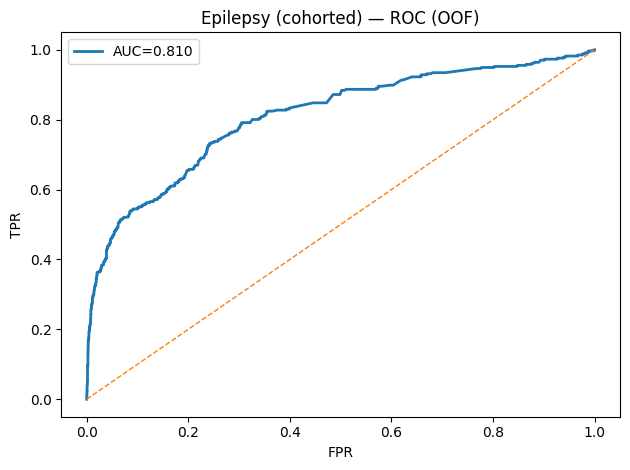

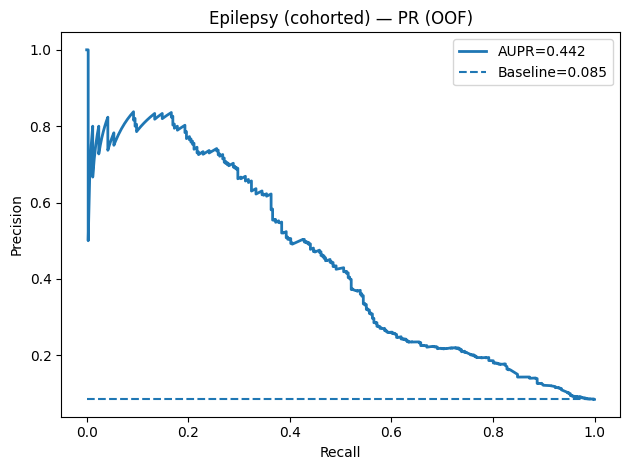

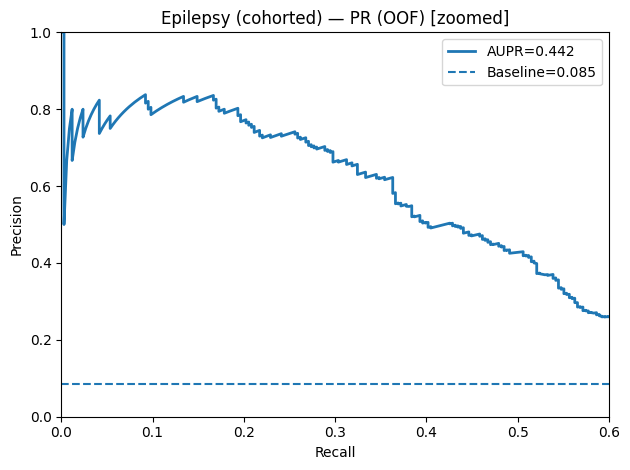

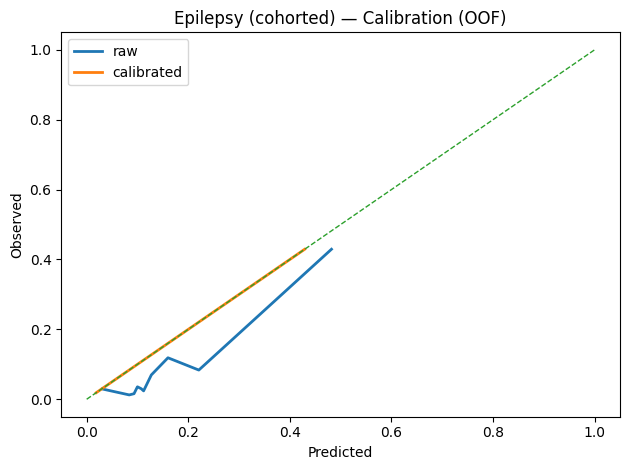

Saved: figs_ep_cohorted/reliability_table.csv


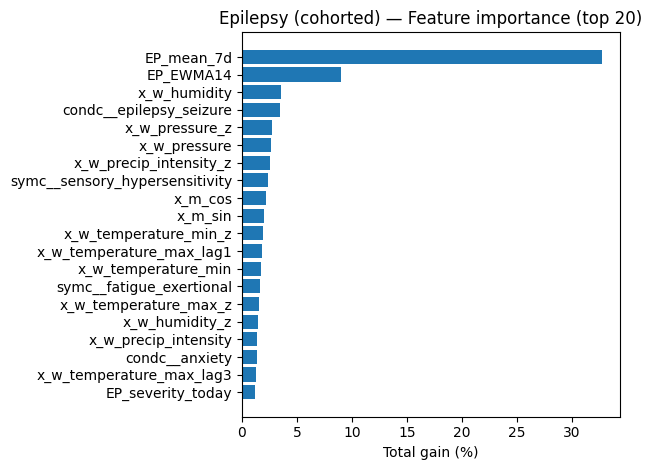

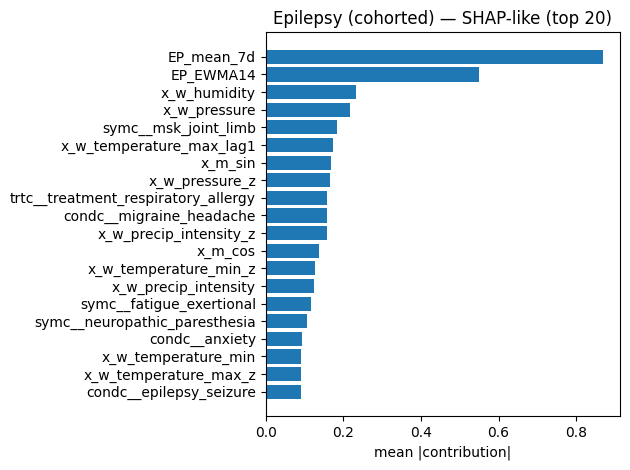

In [14]:
# Build the candidate feature matrix, run group-aware LightGBM CV, calibrate,
# compute gain, permutation AUC drop, SHAP-like contributions, and a consensus rank for epilepsy.

import numpy as np, pandas as pd, matplotlib.pyplot as plt, json, gc, os
from pathlib import Path
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    roc_curve, precision_recall_curve, auc
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
import lightgbm as lgb

# Candidate features (wide)
cand_cols = []
# all cluster families:
cand_cols += [c for c in D.columns if c.startswith(("symc__","condc__","tagc__","foodc__","trtc__"))]
# epilepsy history & severity:
cand_cols += [c for c in ["EP_severity_today","EP_mean_7d","EP_EWMA14","EP_delta_1d"] if c in D.columns]
# weather & compactors:
cand_cols += [c for c in D.columns if c.startswith("x_w_")]
# seasonality / calendar:
cand_cols += [c for c in D.columns if c.startswith("dow_")]
cand_cols += [c for c in ["x_m_sin","x_m_cos"] if c in D.columns]

X_all = D[cand_cols].apply(pd.to_numeric, errors="coerce").astype("float32")
print(f"#candidate features (Epilepsy): {X_all.shape[1]}")

# Univariate screening
def spearman_fast(x, y):
    xr = pd.Series(x).rank(method="average"); yr = pd.Series(y).rank(method="average")
    xr = xr - xr.mean(); yr = yr - yr.mean()
    denom = (xr.std(ddof=0) * yr.std(ddof=0))
    if denom == 0 or np.isnan(denom): return np.nan
    return float((xr*yr).mean() / denom)

def univariate_oof_scores(X, y, groups, n_splits=5, seed=42):
    gkf = GroupKFold(n_splits=n_splits)
    rows = []
    for col in X.columns:
        x = X[col].values
        uniq = pd.Series(x[np.isfinite(x)]).nunique()
        if uniq < 2:
            rows.append([col, np.nan, np.nan, np.nan, np.nan]); continue

        oof = np.zeros_like(y, dtype=float); valid_any = False
        for tr, va in gkf.split(X, y, groups):
            xv = x[va]
            uv = pd.Series(xv[np.isfinite(xv)]).nunique()
            if uv == 2:
                vals = pd.Series(x[tr]); ytr = y[tr]
                p1 = ytr[vals==1].mean() if (vals==1).any() else ytr.mean()
                p0 = ytr[vals==0].mean() if (vals==0).any() else ytr.mean()
                score = np.where(xv==1, p1, p0).astype(float)
            else:
                r = pd.Series(xv).rank(method="average").values
                score = (r - r.min()) / (r.max() - r.min() + 1e-9)
            if np.isfinite(score).any():
                oof[va] = score; valid_any = True

        if valid_any:
            try:
                auc1 = roc_auc_score(y, oof); apr1 = average_precision_score(y, oof)
            except ValueError:
                auc1, apr1 = np.nan, np.nan
        else:
            auc1, apr1 = np.nan, np.nan

        x_mi = np.nan_to_num(x, copy=False)
        try:
            mi = mutual_info_classif(x_mi.reshape(-1,1), y, discrete_features=False, random_state=seed)[0]
        except Exception:
            mi = np.nan

        rho = spearman_fast(x, y)
        rows.append([col, auc1, apr1, mi, rho])

    return pd.DataFrame(rows, columns=["feature","uni_AUC","uni_AUPR","MI","Spearman"]).set_index("feature")

univar = univariate_oof_scores(X_all, y, groups, n_splits=5, seed=RANDOM_STATE)

# Group-aware LightGBM CV
def run_lgbm_groupcv(X, y, groups, n_splits=5, num_boost_round=2000, early_stopping=200, seed=42):
    gkf = GroupKFold(n_splits=n_splits)
    oof = np.zeros(len(y), dtype=float)
    models, iters, folds = [], [], []
    gain_imp = pd.Series(0.0, index=X.columns, dtype=float)

    for k, (tr, va) in enumerate(gkf.split(X, y, groups), 1):
        Xtr, ytr = X.iloc[tr], y[tr]
        Xva, yva = X.iloc[va], y[va]
        pos, neg = ytr.sum(), len(ytr)-ytr.sum()
        spw = (neg / max(pos,1))  # class balance by fold

        params = dict(
            objective="binary", metric="auc",
            learning_rate=0.03, num_leaves=255,
            min_data_in_leaf=60, feature_fraction=0.9, bagging_fraction=0.9, bagging_freq=1,
            lambda_l2=1.0, max_depth=-1, n_jobs=-1, random_state=seed,
            scale_pos_weight=spw, verbose=-1
        )
        clf = lgb.LGBMClassifier(**params, n_estimators=num_boost_round)
        clf.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)], eval_metric="auc",
            callbacks=[lgb.early_stopping(stopping_rounds=early_stopping, verbose=False)]
        )
        bi = clf.best_iteration_ or num_boost_round
        models.append(clf); iters.append(bi); folds.append((tr,va))

        p = clf.predict_proba(Xva, num_iteration=bi)[:,1]
        oof[va] = p

        print(f"[Fold {k}] AUC={roc_auc_score(yva,p):.3f}  AUPR={average_precision_score(yva,p):.3f}  best_iter={bi}")

        gain_imp += pd.Series(
            clf.booster_.feature_importance(importance_type="gain", iteration=bi),
            index=X.columns
        ).fillna(0.0)

    # OOF metrics & calibration
    auroc = roc_auc_score(y, oof)
    aupr  = average_precision_score(y, oof)
    brier = brier_score_loss(y, oof)

    ir = IsotonicRegression(out_of_bounds="clip")
    ir.fit(oof, y)
    oof_cal = ir.predict(oof)
    brier_cal = brier_score_loss(y, oof_cal)

    return dict(
        oof=oof, oof_cal=oof_cal, models=models, iters=np.array(iters), folds=folds,
        gain=gain_imp, auroc=auroc, aupr=aupr, brier=brier, brier_cal=brier_cal, calibrator=ir
    )

cv_all = run_lgbm_groupcv(X_all, y, groups, n_splits=5, num_boost_round=2000, early_stopping=200, seed=RANDOM_STATE)

# Report cohort-aware headline metrics
prev = y.mean()
lift = cv_all["aupr"] / max(prev, 1e-9)
brier_climo = prev*(1 - prev)
bss = 1 - cv_all["brier"] / brier_climo

print("\nOOF metrics (Epilepsy, cohorted, all candidates):")
print("  AUROC = %.3f" % cv_all["auroc"])
print("  AUPR  = %.3f  (baseline=%.3f  lift=%.1fx)" % (cv_all["aupr"], prev, lift))
print("  Brier = %.3f  |  Brier Skill Score vs climatology = %.2f" % (cv_all["brier"], bss))
print("  Calibrated Brier = %.3f" % cv_all["brier_cal"])

# Permutation AUC drop
from copy import deepcopy
gain_sorted = cv_all["gain"].sort_values(ascending=False)
topK = gain_sorted.head(50).index.tolist()

def perm_drop_auc(X, y, cv_obj, feat_list):
    drops = pd.Series(0.0, index=feat_list); counts = pd.Series(0, index=feat_list)
    for (tr, va), model, bi in zip(cv_obj["folds"], cv_obj["models"], cv_obj["iters"]):
        Xva = X.iloc[va].copy()
        base_auc = roc_auc_score(y[va], model.predict_proba(Xva, num_iteration=bi)[:,1])
        rng = np.random.RandomState(42)
        for f in feat_list:
            xx = Xva.copy()
            xx[f] = rng.permutation(xx[f].values)
            p = model.predict_proba(xx, num_iteration=bi)[:,1]
            drops[f] += (base_auc - roc_auc_score(y[va], p)); counts[f] += 1
    return (drops / counts.replace(0, np.nan)).sort_values(ascending=False)

perm_auc_drop = perm_drop_auc(X_all, y, cv_all, topK)

# SHAP-like contributions from best-performing fold
best_idx = int(np.argmax([
    roc_auc_score(y[va], m.predict_proba(X_all.iloc[va], num_iteration=it)[:,1])
    for (tr,va), m, it in zip(cv_all["folds"], cv_all["models"], cv_all["iters"])
]))
best_model = cv_all["models"][best_idx]; best_iter = int(cv_all["iters"][best_idx])

# sample to run quickly
n_sample = min(12000, len(X_all))
idx = np.random.RandomState(42).choice(len(X_all), size=n_sample, replace=False)
X_s = X_all.iloc[idx]

contrib = best_model.booster_.predict(X_s, num_iteration=best_iter, pred_contrib=True)
contrib = np.asarray(contrib)[:, :-1]
shap_like = pd.Series(np.abs(contrib).mean(axis=0), index=X_all.columns).sort_values(ascending=False)

# Consensus ranking
rank = pd.DataFrame(index=X_all.columns)
rank["gain"]      = cv_all["gain"]
rank["perm_auc"]  = perm_auc_drop.reindex(rank.index).fillna(0.0)
rank["shap_like"] = shap_like.reindex(rank.index).fillna(0.0)
rank["uni_AUC"]   = univar["uni_AUC"].reindex(rank.index)
rank["uni_AUPR"]  = univar["uni_AUPR"].reindex(rank.index)
rank["MI"]        = univar["MI"].reindex(rank.index)
rank["Spearman"]  = univar["Spearman"].reindex(rank.index)

def to_rank(s): return s.rank(method="average", ascending=False)
ranked = pd.DataFrame({
    "r_gain":      to_rank(rank["gain"]),
    "r_perm":      to_rank(rank["perm_auc"]),
    "r_shap":      to_rank(rank["shap_like"]),
    "r_uniAUC":    to_rank(rank["uni_AUC"].fillna(-np.inf)),
    "r_uniAUPR":   to_rank(rank["uni_AUPR"].fillna(-np.inf)),
    "r_MI":        to_rank(rank["MI"].fillna(-np.inf)),
    "r_Spearman":  to_rank(rank["Spearman"].abs().fillna(-np.inf)),
})
ranked["consensus"] = ranked.mean(axis=1)

top_consensus = ranked.sort_values("consensus", ascending=True).head(30)
display(top_consensus)
top_consensus.to_csv("EP_feature_consensus_top30_cohorted.csv", index=True)
print("Saved: EP_feature_consensus_top30_cohorted.csv")

# Figures & reliability table
Path("figs_ep_cohorted").mkdir(exist_ok=True)

# ROC
fpr, tpr, _ = roc_curve(y, cv_all["oof"])
roc_auc = auc(fpr, tpr)
plt.figure(); plt.plot(fpr, tpr, linewidth=2, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],"--", linewidth=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Epilepsy (cohorted) — ROC (OOF)"); plt.legend()
plt.tight_layout(); plt.savefig("figs_ep_cohorted/roc.png", dpi=150); plt.show()

# PR
prec, rec, _ = precision_recall_curve(y, cv_all["oof"])
pr_auc = auc(rec, prec); base = y.mean()
plt.figure(); plt.plot(rec, prec, linewidth=2, label=f"AUPR={pr_auc:.3f}")
plt.hlines(base, 0, 1, linestyles="--", label=f"Baseline={base:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Epilepsy (cohorted) — PR (OOF)"); plt.legend()
plt.tight_layout(); plt.savefig("figs_ep_cohorted/pr.png", dpi=150); plt.show()

# PR zoom
plt.figure(); plt.plot(rec, prec, linewidth=2, label=f"AUPR={pr_auc:.3f}")
plt.hlines(base, 0, 1, linestyles="--", label=f"Baseline={base:.3f}")
plt.xlim(0, 0.6); plt.ylim(0, 1.0)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Epilepsy (cohorted) — PR (OOF) [zoomed]"); plt.legend()
plt.tight_layout(); plt.savefig("figs_ep_cohorted/pr_zoom.png", dpi=150); plt.show()

# Calibration (raw vs isotonic)
pt_raw, pp_raw = calibration_curve(y, cv_all["oof"], n_bins=10, strategy="quantile")
pt_cal, pp_cal = calibration_curve(y, cv_all["oof_cal"], n_bins=10, strategy="quantile")
plt.figure()
plt.plot(pp_raw, pt_raw, linewidth=2, label="raw")
plt.plot(pp_cal, pt_cal, linewidth=2, label="calibrated")
plt.plot([0,1],[0,1], "--", linewidth=1)
plt.xlabel("Predicted"); plt.ylabel("Observed"); plt.title("Epilepsy (cohorted) — Calibration (OOF)")
plt.legend(); plt.tight_layout(); plt.savefig("figs_ep_cohorted/calibration.png", dpi=150); plt.show()

# Reliability table with counts per bin (use calibrated scores)
bins = np.quantile(cv_all["oof_cal"], np.linspace(0,1,11))
b = np.digitize(cv_all["oof_cal"], bins[1:-1], right=True)
reliability = pd.DataFrame({
    "bin": np.arange(10),
    "n":   [np.sum(b==i) for i in range(10)],
    "pred_mean": [cv_all["oof_cal"][b==i].mean() if (b==i).any() else np.nan for i in range(10)],
    "obs_rate":  [y[b==i].mean() if (b==i).any() else np.nan for i in range(10)],
})
reliability.to_csv("figs_ep_cohorted/reliability_table.csv", index=False)
print("Saved: figs_ep_cohorted/reliability_table.csv")

# Importance (gain) for quick visual context
gain = cv_all["gain"]; gain_norm = 100*gain/(gain.sum() if gain.sum()>0 else 1.0)
order = gain_norm.sort_values(ascending=True)
top20 = order.tail(20)
plt.figure()
plt.barh(top20.index, top20.values)
plt.xlabel("Total gain (%)"); plt.title("Epilepsy (cohorted) — Feature importance (top 20)")
plt.tight_layout(); plt.savefig("figs_ep_cohorted/importance_top20.png", dpi=150); plt.show()

# SHAP-like contributions on best fold
contrib = best_model.booster_.predict(X_all, num_iteration=best_iter, pred_contrib=True)
mac = np.abs(np.asarray(contrib)[:, :-1]).mean(axis=0)
shap_like_all = pd.Series(mac, index=X_all.columns).sort_values(ascending=True)
plt.figure(); top20s = shap_like_all.tail(20)
plt.barh(top20s.index, top20s.values)
plt.xlabel("mean |contribution|"); plt.title("Epilepsy (cohorted) — SHAP-like (top 20)")
plt.tight_layout(); plt.savefig("figs_ep_cohorted/shap_like_top20.png", dpi=150); plt.show()



### Feature Picking

NEURO feature: symc__tremor_spasm_twitch
MOOD  feature: symc__negative_affect
WX    feature: x_w_humidity_z
EP_6  (6 feats): ['EP_mean_7d', 'EP_EWMA14', 'EP_severity_today', 'condc__epilepsy_seizure', 'symc__tremor_spasm_twitch', 'symc__sleep_disorders']
EP_8  (8 feats): ['EP_mean_7d', 'EP_EWMA14', 'EP_severity_today', 'condc__epilepsy_seizure', 'symc__tremor_spasm_twitch', 'symc__sleep_disorders', 'symc__negative_affect', 'x_m_cos']
EP_10  (10 feats): ['EP_mean_7d', 'EP_EWMA14', 'EP_severity_today', 'condc__epilepsy_seizure', 'symc__tremor_spasm_twitch', 'symc__sleep_disorders', 'symc__negative_affect', 'x_m_cos', 'EP_delta_1d', 'x_w_humidity_z']
EP_12  (11 feats): ['EP_mean_7d', 'EP_EWMA14', 'EP_severity_today', 'condc__epilepsy_seizure', 'symc__tremor_spasm_twitch', 'symc__sleep_disorders', 'symc__negative_affect', 'x_m_cos', 'EP_delta_1d', 'x_w_humidity_z', 'x_m_sin']

=== EP_6 | #features=6 ===
[Fold 1] AUC=0.723  AUPR=0.095  best_iter=4
[Fold 2] AUC=0.782  AUPR=0.218  best_iter=4

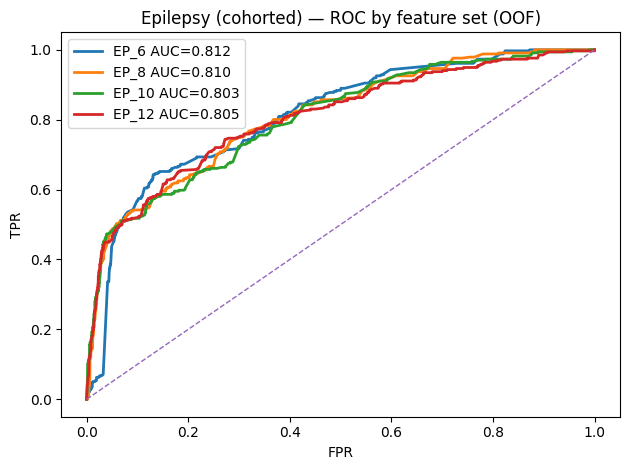

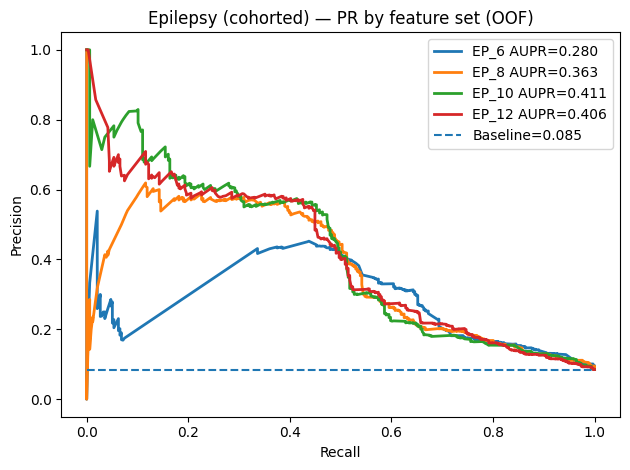


Selected set: EP_10 (10 feats)
['EP_mean_7d', 'EP_EWMA14', 'EP_severity_today', 'condc__epilepsy_seizure', 'symc__tremor_spasm_twitch', 'symc__sleep_disorders', 'symc__negative_affect', 'x_m_cos', 'EP_delta_1d', 'x_w_humidity_z']


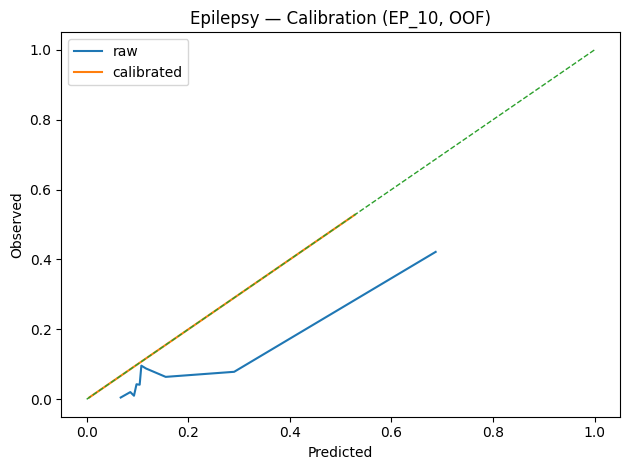

Saved: figs_ep_final/reliability_table_best.csv


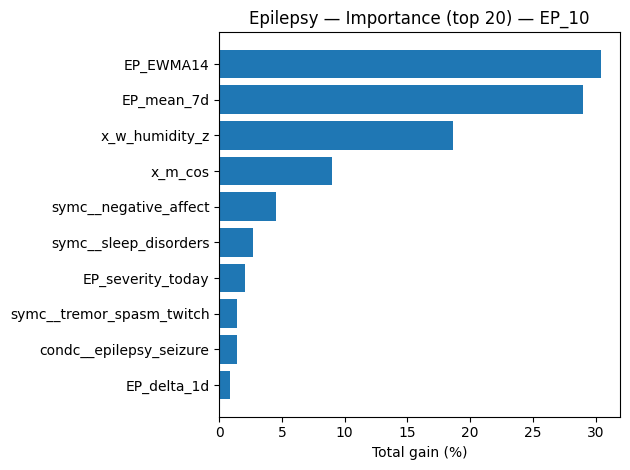

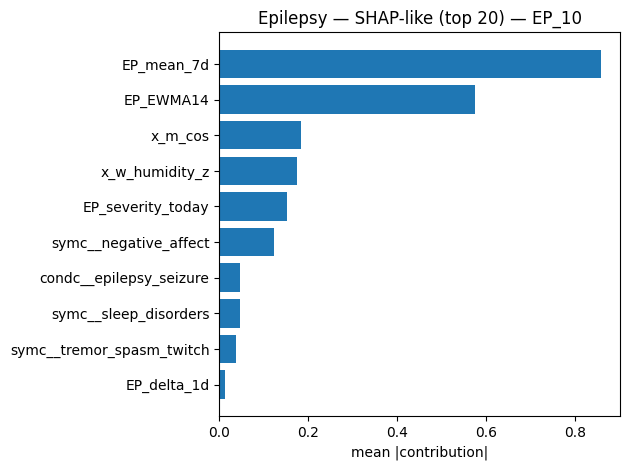

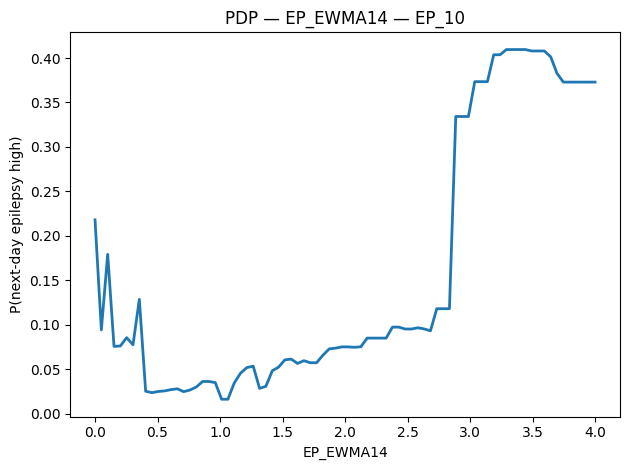

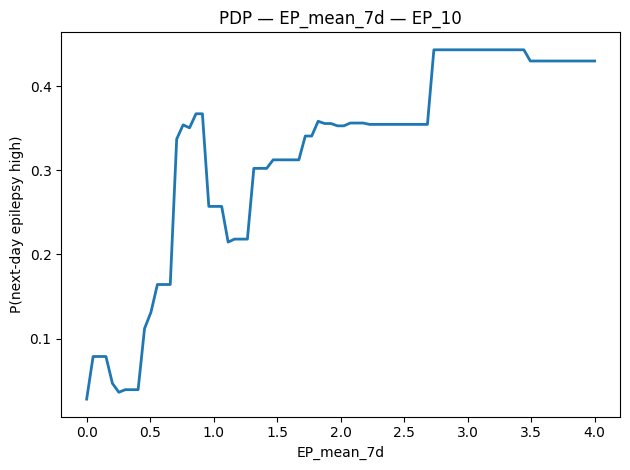

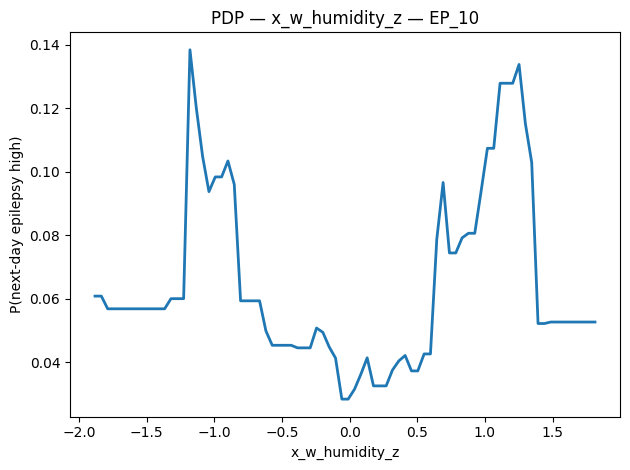

Youden-J: t=0.088 | Sens=0.580 Spec=0.865 Prec=0.285 | TP=195 FP=490 FN=141 TN=3129
Max-F1: t=0.250 | Sens=0.473 Spec=0.961 Prec=0.528 | TP=159 FP=142 FN=177 TN=3477
Prec≥0.50: t=0.106 | Sens=0.512 Spec=0.930 Prec=0.406 | TP=172 FP=252 FN=164 TN=3367
Saved:
  models_ep_final/ep_lgbm_EP_10.txt
  models_ep_final/ep_isotonic_EP_10.joblib
  models_ep_final/ep_features_EP_10.json


In [15]:
# Define compact epilepsy feature sets (6, 8, 10, 12 features)
# based on the cohorted rankings/plots above

Path("figs_ep_final").mkdir(exist_ok=True)

# Helpers to choose a neuro-ish symptom and a mood/affect feature
def choose_neuro(D):
    for c in [
        "symc__tremor_spasm_twitch",
        "symc__neuropathic_paresthesia",
        "symc__sensory_hypersensitivity",
        "symc__cognitive_dysfunction",
    ]:
        if c in D.columns:
            return c
    return None

def choose_mood(D):
    for c in [
        "symc__negative_affect",
        "condc__anxiety",
        "condc__depression",
    ]:
        if c in D.columns:
            return c
    return None

def choose_weather(D):
    # try z-scores first, fall back to raw
    for c in [
        "x_w_humidity_z",
        "x_w_precip_intensity_z",
        "x_w_pressure_z",
        "x_w_temperature_min_z",
        "x_w_humidity",
        "x_w_precip_intensity",
        "x_w_pressure",
        "x_w_temperature_min",
    ]:
        if c in D.columns:
            return c
    return None

NEURO = choose_neuro(D)
MOOD  = choose_mood(D)
WX    = choose_weather(D)

print("NEURO feature:", NEURO)
print("MOOD  feature:", MOOD)
print("WX    feature:", WX)

# Base 6-feature core (history + seizure condition + neuro + sleep)
CORE6 = [
    "EP_mean_7d",
    "EP_EWMA14",
    "EP_severity_today",
    "condc__epilepsy_seizure",
    NEURO,
    "symc__sleep_disorders",
]
CORE6 = [c for c in CORE6 if c is not None]

SET_6  = CORE6
SET_8  = CORE6 + [MOOD, "x_m_cos"]
SET_10 = SET_8 + ["EP_delta_1d", WX]
SET_12 = SET_10 + ["x_m_sin"]  # typically gives you 10-12 features depending on availability

def sanitize(s, D):
    seen = set(); out = []
    for c in s:
        if c is None or c not in D.columns:
            continue
        if c in seen:
            continue
        seen.add(c); out.append(c)
    return out

FEATURE_SETS = {
    "EP_6":  sanitize(SET_6,  D),
    "EP_8":  sanitize(SET_8,  D),
    "EP_10": sanitize(SET_10, D),
    "EP_12": sanitize(SET_12, D),
}

for name, feats in FEATURE_SETS.items():
    print(f"{name}  ({len(feats)} feats): {feats}")

# Group-aware LGBM CV (same structure as IA feature-picking)

def run_lgbm_groupcv(X, y, groups, n_splits=5, seed=42):
    gkf = GroupKFold(n_splits=n_splits)
    oof = np.zeros(len(y), dtype=float)
    models, iters, folds = [], [], []

    for k, (tr, va) in enumerate(gkf.split(X, y, groups), 1):
        Xtr, ytr = X.iloc[tr], y[tr]
        Xva, yva = X.iloc[va], y[va]
        pos, neg = ytr.sum(), len(ytr)-ytr.sum()
        spw = (neg / max(pos,1))

        params = dict(
            objective="binary", metric="auc",
            learning_rate=0.03, num_leaves=255,
            min_data_in_leaf=60, feature_fraction=0.9,
            bagging_fraction=0.9, bagging_freq=1,
            lambda_l2=1.0, max_depth=-1, n_jobs=-1,
            random_state=seed, scale_pos_weight=spw, verbose=-1
        )
        clf = lgb.LGBMClassifier(**params, n_estimators=2000)
        clf.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)], eval_metric="auc",
            callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
        )
        bi = clf.best_iteration_ or 2000
        models.append(clf); iters.append(bi); folds.append((tr,va))
        oof[va] = clf.predict_proba(Xva, num_iteration=bi)[:,1]
        print(f"[Fold {k}] AUC={roc_auc_score(yva,oof[va]):.3f}  AUPR={average_precision_score(yva,oof[va]):.3f}  best_iter={bi}")

    auroc = roc_auc_score(y, oof)
    aupr  = average_precision_score(y, oof)
    brier = brier_score_loss(y, oof)

    ir = IsotonicRegression(out_of_bounds="clip").fit(oof, y)
    oof_cal = ir.predict(oof)
    brier_cal = brier_score_loss(y, oof_cal)

    return dict(oof=oof, oof_cal=oof_cal, models=models, iters=np.array(iters),
                folds=folds, auroc=auroc, aupr=aupr, brier=brier, brier_cal=brier_cal, calibrator=ir)

results = {}
for name, feats in FEATURE_SETS.items():
    if not feats:
        print(f"\n=== {name}: skipped (no available features) ===")
        continue
    X = D[feats].apply(pd.to_numeric, errors="coerce").astype("float32").fillna(0.0)
    print(f"\n=== {name} | #features={X.shape[1]} ===")
    res = run_lgbm_groupcv(X, y, groups, n_splits=5, seed=42)
    results[name] = (feats, X, res)
    prev = y.mean()
    lift = res["aupr"]/prev
    brier_climo = prev*(1-prev)
    bss = 1 - res["brier"]/brier_climo
    print(f"OOF: AUROC={res['auroc']:.3f}  AUPR={res['aupr']:.3f} (baseline={prev:.3f}, lift={lift:.1f}x)  "
          f"Brier={res['brier']:.3f}  CalBrier={res['brier_cal']:.3f}  BSS={bss:.2f}")

# Overlay ROC / PR for all sets

plt.figure()
for name,(feats,X,res) in results.items():
    fpr, tpr, _ = roc_curve(y, res["oof"])
    plt.plot(fpr, tpr, lw=2, label=f"{name} AUC={auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],"--", lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Epilepsy (cohorted) — ROC by feature set (OOF)")
plt.legend(); plt.tight_layout(); plt.savefig("figs_ep_final/roc_overlaid.png", dpi=150); plt.show()

plt.figure()
for name,(feats,X,res) in results.items():
    pr, rc, _ = precision_recall_curve(y, res["oof"])
    plt.plot(rc, pr, lw=2, label=f"{name} AUPR={auc(rc,pr):.3f}")
plt.hlines(y.mean(), 0, 1, linestyles="--", label=f"Baseline={y.mean():.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Epilepsy (cohorted) — PR by feature set (OOF)")
plt.legend(); plt.tight_layout(); plt.savefig("figs_ep_final/pr_overlaid.png", dpi=150); plt.show()

# Pick the best set by AUPR

best_name = max(results.keys(), key=lambda k: results[k][2]["aupr"])
best_feats, best_X, best_res = results[best_name]
print(f"\nSelected set: {best_name} ({len(best_feats)} feats)\n{best_feats}")

# Calibration plot & reliability table for the best set

pt_raw, pp_raw = calibration_curve(y, best_res["oof"], n_bins=10, strategy="quantile")
pt_cal, pp_cal = calibration_curve(y, best_res["oof_cal"], n_bins=10, strategy="quantile")
plt.figure()
plt.plot(pp_raw, pt_raw, label="raw")
plt.plot(pp_cal, pt_cal, label="calibrated")
plt.plot([0,1],[0,1],"--", lw=1)
plt.xlabel("Predicted"); plt.ylabel("Observed")
plt.title(f"Epilepsy — Calibration ({best_name}, OOF)")
plt.legend(); plt.tight_layout()
plt.savefig("figs_ep_final/calibration_best.png", dpi=150); plt.show()

bins = np.quantile(best_res["oof_cal"], np.linspace(0,1,11))
b = np.digitize(best_res["oof_cal"], bins[1:-1], right=True)
reliability = pd.DataFrame({
    "bin": np.arange(10),
    "n":   [np.sum(b==i) for i in range(10)],
    "pred_mean": [best_res["oof_cal"][b==i].mean() if (b==i).any() else np.nan for i in range(10)],
    "obs_rate":  [y[b==i].mean() if (b==i).any() else np.nan for i in range(10)],
})
Path("figs_ep_final").mkdir(exist_ok=True)
reliability.to_csv("figs_ep_final/reliability_table_best.csv", index=False)
print("Saved: figs_ep_final/reliability_table_best.csv")

# Importance & SHAP-like bars; PDPs for top 3 features

from sklearn.metrics import roc_auc_score

best_idx = int(np.argmax([
    roc_auc_score(y[va], m.predict_proba(best_X.iloc[va], num_iteration=it)[:,1])
    for (tr,va), m, it in zip(best_res["folds"], best_res["models"], best_res["iters"])
]))
best_model = best_res["models"][best_idx]; best_iter = int(best_res["iters"][best_idx])

gain = pd.Series(best_model.booster_.feature_importance(importance_type="gain", iteration=best_iter),
                 index=best_X.columns)
gain = 100 * gain / (gain.sum() if gain.sum() > 0 else 1.0)
order = gain.sort_values(ascending=True).tail(20)
plt.figure(); plt.barh(order.index, order.values)
plt.xlabel("Total gain (%)"); plt.title(f"Epilepsy — Importance (top 20) — {best_name}")
plt.tight_layout(); plt.savefig("figs_ep_final/importance_top20_best.png", dpi=150); plt.show()

contrib = best_model.booster_.predict(best_X, num_iteration=best_iter, pred_contrib=True)
mac = np.abs(np.asarray(contrib)[:, :-1]).mean(axis=0)
shap_like = pd.Series(mac, index=best_X.columns).sort_values(ascending=True).tail(20)
plt.figure(); plt.barh(shap_like.index, shap_like.values)
plt.xlabel("mean |contribution|"); plt.title(f"Epilepsy — SHAP-like (top 20) — {best_name}")
plt.tight_layout(); plt.savefig("figs_ep_final/shap_like_top20_best.png", dpi=150); plt.show()

def pdp_1d(model, X, feat, it, n=80):
    x = X[feat]; grid = np.linspace(np.nanpercentile(x,1), np.nanpercentile(x,99), n)
    med = X.median(numeric_only=True)
    preds = []
    for v in grid:
        r = med.copy(); r[feat]=v
        preds.append(model.predict_proba(pd.DataFrame([r], columns=X.columns), num_iteration=it)[:,1][0])
    plt.figure(); plt.plot(grid, preds, lw=2)
    plt.xlabel(feat); plt.ylabel("P(next-day epilepsy high)")
    plt.title(f"PDP — {feat} — {best_name}")
    plt.tight_layout(); plt.savefig(f"figs_ep_final/pdp_{feat}_{best_name}.png", dpi=150); plt.show()

top3 = gain.sort_values(ascending=False).head(3).index.tolist()
for f in top3:
    pdp_1d(best_model, best_X, f, best_iter)

# Thresholds (Youden-J, max-F1, precision>=0.50)

from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, f1_score

p_cal = best_res["oof_cal"]

def print_confusion(y_true, p_cal, t, label):
    yh = (p_cal >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yh).ravel()
    sens = tp/(tp+fn+1e-9); spec = tn/(tn+fp+1e-9); prec = tp/(tp+fp+1e-9)
    print(f"{label}: t={t:.3f} | Sens={sens:.3f} Spec={spec:.3f} Prec={prec:.3f} | TP={tp} FP={fp} FN={fn} TN={tn}")

fpr, tpr, thr = roc_curve(y, p_cal); j = tpr - fpr; t_j = thr[np.argmax(j)]
pr, rc, thr_pr = precision_recall_curve(y, p_cal); f1 = 2*pr*rc/(pr+rc+1e-9); t_f1 = thr_pr[np.argmax(f1[:-1])]

order_idx = np.argsort(-p_cal); cum_tp = np.cumsum(y[order_idx]); cum_fp = np.cumsum(1 - y[order_idx])
precision_curve = cum_tp / (cum_tp + cum_fp + 1e-9)
idx = np.where(precision_curve >= 0.50)[0]
t_p50 = p_cal[order_idx[idx[-1]]] if idx.size>0 else 1.0

print_confusion(y, p_cal, t_j,   "Youden-J")
print_confusion(y, p_cal, t_f1,  "Max-F1")
print_confusion(y, p_cal, t_p50, "Prec≥0.50")

# Fit best feature set on ALL rows; save booster + calibrator + simple model card

import joblib

Path("models_ep_final").mkdir(exist_ok=True)

final_rounds = int(np.clip(np.round(best_res["iters"].mean()), 100, 2000))
pos = y.sum(); neg = len(y)-y.sum(); spw = (neg/max(pos,1))

params = dict(
    objective="binary", learning_rate=0.03, num_leaves=255,
    min_data_in_leaf=60, feature_fraction=0.9, bagging_fraction=0.9,
    bagging_freq=1, lambda_l2=1.0, max_depth=-1, n_jobs=-1,
    random_state=42, scale_pos_weight=spw, verbose=-1
)
final = lgb.LGBMClassifier(**params, n_estimators=final_rounds).fit(best_X, y)

final.booster_.save_model(f"models_ep_final/ep_lgbm_{best_name}.txt")
joblib.dump(best_res["calibrator"], f"models_ep_final/ep_isotonic_{best_name}.joblib")
with open(f"models_ep_final/ep_features_{best_name}.json","w") as f:
    json.dump({
        "feature_names": list(best_X.columns),
        "num_boost_round": final_rounds,
        "cohort_rule": "any_EP_ge1",
        "label": "next-day epilepsy high (>=3)",
        "training_rows": int(len(D)),
        "training_users": int(D['user_id'].nunique()),
        "oof": {
            "auroc": float(best_res["auroc"]),
            "aupr":  float(best_res["aupr"]),
            "baseline_prevalence": float(y.mean()),
            "brier": float(best_res["brier"]),
            "brier_calibrated": float(best_res["brier_cal"])
        }
    }, f, indent=2)

print(f"Saved:\n  models_ep_final/ep_lgbm_{best_name}.txt\n  models_ep_final/ep_isotonic_{best_name}.joblib\n  models_ep_final/ep_features_{best_name}.json")

### Final Model

EP_10 features (10): ['EP_mean_7d', 'EP_EWMA14', 'EP_severity_today', 'condc__epilepsy_seizure', 'symc__tremor_spasm_twitch', 'symc__sleep_disorders', 'symc__negative_affect', 'x_m_cos', 'EP_delta_1d', 'x_w_humidity_z']
[Fold 1] AUC=0.693  AUPR=0.080  best_iter=1
[Fold 2] AUC=0.770  AUPR=0.171  best_iter=1
[Fold 3] AUC=0.799  AUPR=0.247  best_iter=6
[Fold 4] AUC=0.869  AUPR=0.618  best_iter=66
[Fold 5] AUC=0.522  AUPR=0.070  best_iter=7

[EP_10 OOF]
  AUROC = 0.803
  AUPR  = 0.411  (baseline=0.085, lift=4.8x)
  Brier = 0.077  |  Calibrated Brier = 0.059  |  BSS=0.00


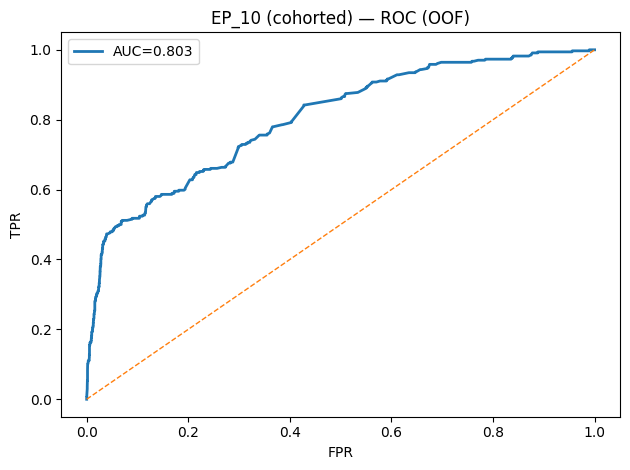

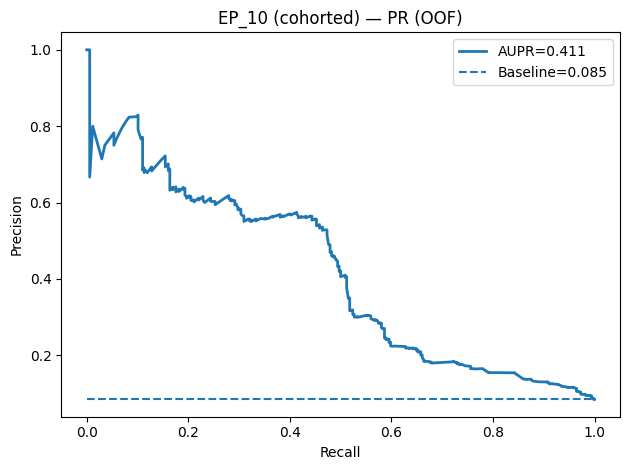

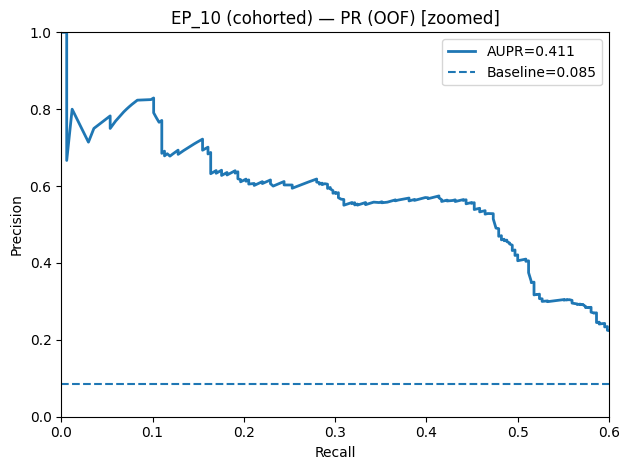

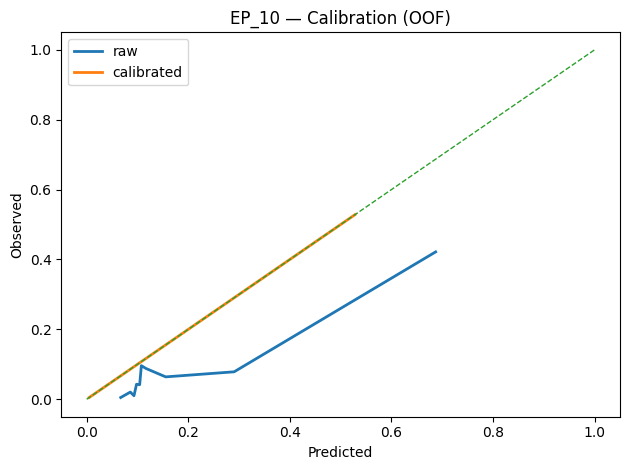

Saved: figs_ep10_final/reliability_table.csv


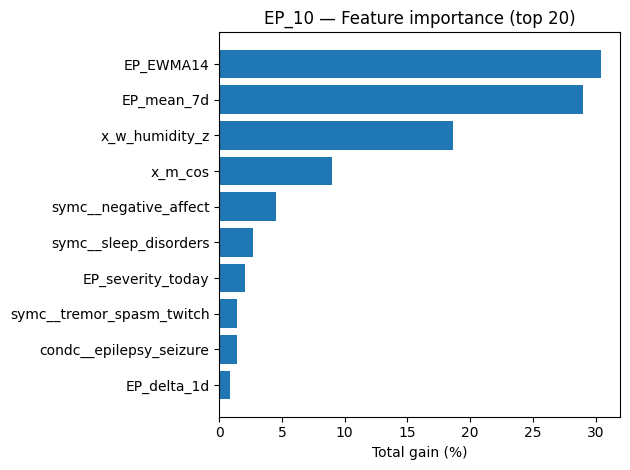

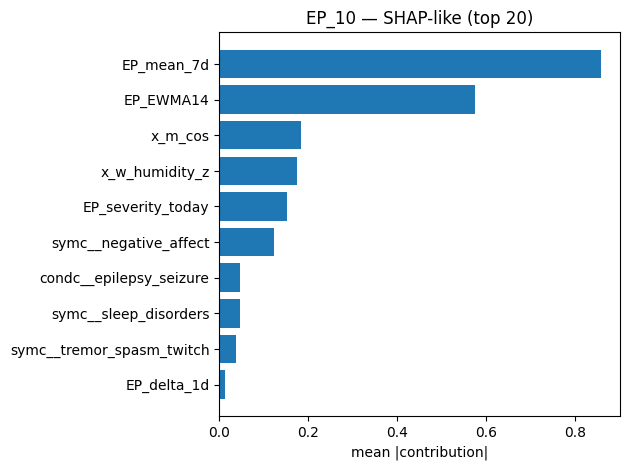

Saved: figs_ep10_final/thresholds_summary.csv


,threshold,precision,recall,specificity,f1,TP,FP,FN,TN
0,0.050000,0.154645,0.842262,0.572534,0.261311,283,1547,53,2072
3,0.088123,0.284672,0.580357,0.864603,0.381978,195,490,141,3129
1,0.100000,0.405660,0.511905,0.930368,0.452632,172,252,164,3367
2,0.200000,0.528239,0.473214,0.960763,0.499215,159,142,177,3477
4,0.250000,0.528239,0.473214,0.960763,0.499215,159,142,177,3477


Saved:
  models_ep10_final/ep10_lgbm.txt
  models_ep10_final/ep10_isotonic.joblib
  models_ep10_final/ep10_features.json
  models_ep10_final/ep10_model_card.json


In [17]:
# Build the EP_10 feature matrix, run GroupKFold CV with isotonic calibration,
# plot ROC/PR/Calibration, save reliability table, thresholds, and final booster+card.

Path("figs_ep10_final").mkdir(exist_ok=True)

# 1) Define EP_10 feature set (sanitize against D)
EP_10 = [
    "EP_mean_7d", "EP_EWMA14", "EP_severity_today",
    "condc__epilepsy_seizure",
    "symc__tremor_spasm_twitch",
    "symc__sleep_disorders",
    "symc__negative_affect",
    "x_m_cos",
    "EP_delta_1d",
    "x_w_humidity_z",
]
EP_10 = [c for c in EP_10 if c in D.columns]  # drop any missing

print(f"EP_10 features ({len(EP_10)}): {EP_10}")

# Candidate matrix
X10 = D[EP_10].apply(pd.to_numeric, errors="coerce").astype("float32").fillna(0.0)

# 2) Group-aware LightGBM CV with isotonic calibration
def run_lgbm_groupcv_ep(X, y, groups, n_splits=5, seed=42):
    gkf = GroupKFold(n_splits=n_splits)
    oof = np.zeros(len(y), dtype=float)
    models, iters, folds = [], [], []

    for k, (tr, va) in enumerate(gkf.split(X, y, groups), 1):
        Xtr, ytr = X.iloc[tr], y[tr]
        Xva, yva = X.iloc[va], y[va]
        pos, neg = ytr.sum(), len(ytr)-ytr.sum()
        spw = (neg / max(pos,1))  # class balance

        params = dict(
            objective="binary", metric="auc",
            learning_rate=0.03, num_leaves=255,
            min_data_in_leaf=60, feature_fraction=0.9,
            bagging_fraction=0.9, bagging_freq=1,
            lambda_l2=1.0, max_depth=-1, n_jobs=-1,
            random_state=seed, scale_pos_weight=spw, verbose=-1
        )
        clf = lgb.LGBMClassifier(**params, n_estimators=2000)
        clf.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)], eval_metric="auc",
            callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
        )
        bi = clf.best_iteration_ or 2000
        models.append(clf); iters.append(bi); folds.append((tr,va))
        p = clf.predict_proba(Xva, num_iteration=bi)[:,1]
        oof[va] = p
        print(f"[Fold {k}] AUC={roc_auc_score(yva,p):.3f}  AUPR={average_precision_score(yva,p):.3f}  best_iter={bi}")

    # OOF metrics
    auroc = roc_auc_score(y, oof)
    aupr  = average_precision_score(y, oof)
    brier = brier_score_loss(y, oof)

    # Isotonic calibration
    ir = IsotonicRegression(out_of_bounds="clip").fit(oof, y)
    oof_cal = ir.predict(oof)
    brier_cal = brier_score_loss(y, oof_cal)

    return dict(
        oof=oof, oof_cal=oof_cal, models=models, iters=np.array(iters),
        folds=folds, auroc=auroc, aupr=aupr, brier=brier, brier_cal=brier_cal, calibrator=ir
    )

cv10 = run_lgbm_groupcv_ep(X10, y, groups, n_splits=5, seed=RANDOM_STATE)

# 3) Headline metrics + plots
prev = y.mean()
lift = cv10["aupr"]/prev
brier_climo = prev*(1-prev)
bss = 1 - cv10["brier"]/brier_climo

print("\n[EP_10 OOF]")
print(f"  AUROC = {cv10['auroc']:.3f}")
print(f"  AUPR  = {cv10['aupr']:.3f}  (baseline={prev:.3f}, lift={lift:.1f}x)")
print(f"  Brier = {cv10['brier']:.3f}  |  Calibrated Brier = {cv10['brier_cal']:.3f}  |  BSS={bss:.2f}")

# ROC
fpr, tpr, _ = roc_curve(y, cv10["oof"])
plt.figure(); plt.plot(fpr, tpr, lw=2, label=f"AUC={auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],"--", lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("EP_10 (cohorted) — ROC (OOF)"); plt.legend()
plt.tight_layout(); plt.savefig("figs_ep10_final/roc.png", dpi=150); plt.show()

# PR
pr, rc, _ = precision_recall_curve(y, cv10["oof"])
plt.figure(); plt.plot(rc, pr, lw=2, label=f"AUPR={auc(rc,pr):.3f}")
plt.hlines(prev, 0, 1, linestyles="--", label=f"Baseline={prev:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("EP_10 (cohorted) — PR (OOF)"); plt.legend()
plt.tight_layout(); plt.savefig("figs_ep10_final/pr.png", dpi=150); plt.show()

# PR zoom
plt.figure(); plt.plot(rc, pr, lw=2, label=f"AUPR={auc(rc,pr):.3f}")
plt.hlines(prev, 0, 1, linestyles="--", label=f"Baseline={prev:.3f}")
plt.xlim(0, 0.6); plt.ylim(0, 1.0)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("EP_10 (cohorted) — PR (OOF) [zoomed]"); plt.legend()
plt.tight_layout(); plt.savefig("figs_ep10_final/pr_zoom.png", dpi=150); plt.show()

# Calibration (raw vs calibrated)
pt_raw, pp_raw = calibration_curve(y, cv10["oof"], n_bins=10, strategy="quantile")
pt_cal, pp_cal = calibration_curve(y, cv10["oof_cal"], n_bins=10, strategy="quantile")
plt.figure(); plt.plot(pp_raw, pt_raw, lw=2, label="raw")
plt.plot(pp_cal, pt_cal, lw=2, label="calibrated"); plt.plot([0,1],[0,1],"--", lw=1)
plt.xlabel("Predicted"); plt.ylabel("Observed"); plt.title("EP_10 — Calibration (OOF)")
plt.legend(); plt.tight_layout(); plt.savefig("figs_ep10_final/calibration.png", dpi=150); plt.show()

# Reliability table (calibrated)
bins = np.quantile(cv10["oof_cal"], np.linspace(0,1,11))
b = np.digitize(cv10["oof_cal"], bins[1:-1], right=True)
reliability = pd.DataFrame({
    "bin": np.arange(10),
    "n":   [np.sum(b==i) for i in range(10)],
    "pred_mean": [cv10["oof_cal"][b==i].mean() if (b==i).any() else np.nan for i in range(10)],
    "obs_rate":  [y[b==i].mean() if (b==i).any() else np.nan for i in range(10)],
})
reliability.to_csv("figs_ep10_final/reliability_table.csv", index=False)
print("Saved: figs_ep10_final/reliability_table.csv")

# 4) Interpretability + thresholds

from sklearn.metrics import confusion_matrix

# Best fold by AUC for SHAP-like values
best_idx = int(np.argmax([
    roc_auc_score(y[va], m.predict_proba(X10.iloc[va], num_iteration=it)[:,1])
    for (tr,va), m, it in zip(cv10["folds"], cv10["models"], cv10["iters"])
]))
best_model = cv10["models"][best_idx]; best_iter = int(cv10["iters"][best_idx])

# Gain importance
gain = pd.Series(best_model.booster_.feature_importance(importance_type="gain", iteration=best_iter),
                 index=X10.columns)
gain = 100 * gain / (gain.sum() if gain.sum() > 0 else 1.0)
top_gain = gain.sort_values(ascending=True).tail(20)
plt.figure(); plt.barh(top_gain.index, top_gain.values)
plt.xlabel("Total gain (%)"); plt.title("EP_10 — Feature importance (top 20)")
plt.tight_layout(); plt.savefig("figs_ep10_final/importance_top20.png", dpi=150); plt.show()

# SHAP-like bars
contrib = best_model.booster_.predict(X10, num_iteration=best_iter, pred_contrib=True)
mac = np.abs(np.asarray(contrib)[:, :-1]).mean(axis=0)
shap_like = pd.Series(mac, index=X10.columns).sort_values(ascending=True).tail(20)
plt.figure(); plt.barh(shap_like.index, shap_like.values)
plt.xlabel("mean |contribution|"); plt.title("EP_10 — SHAP-like (top 20)")
plt.tight_layout(); plt.savefig("figs_ep10_final/shap_like_top20.png", dpi=150); plt.show()

# Threshold table (calibrated probabilities)
p_cal = cv10["oof_cal"]

def row_for(t):
    yh = (p_cal >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, yh).ravel()
    sens = tp/(tp+fn+1e-9); spec = tn/(tn+fp+1e-9); prec = tp/(tp+fp+1e-9)
    f1   = 2*prec*sens/(prec+sens+1e-9)
    return dict(threshold=t, precision=prec, recall=sens, specificity=spec, f1=f1,
                TP=tp, FP=fp, FN=fn, TN=tn)

# You already saw approximate thresholds from earlier EP_10 run:
fpr, tpr, thr = roc_curve(y, p_cal); j = tpr - fpr; t_j = thr[np.argmax(j)]
pr, rc, thr_pr = precision_recall_curve(y, p_cal); f1 = 2*pr*rc/(pr+rc+1e-9); t_f1 = thr_pr[np.argmax(f1[:-1])]

# A few fixed thresholds for the UI
grid = [0.05, 0.10, 0.20, t_j, t_f1]
table = pd.DataFrame([row_for(t) for t in grid]).sort_values("threshold")
table.to_csv("figs_ep10_final/thresholds_summary.csv", index=False)
print("Saved: figs_ep10_final/thresholds_summary.csv")
display(table)

# 5) Fit final LightGBM on all data with EP_10, save booster, calibrator (from OOF),
# and a simple model card.

import joblib

Path("models_ep10_final").mkdir(exist_ok=True)

# Reasonable n_estimators: mean best iteration across folds (clamped 100..2000)
final_rounds = int(np.clip(np.round(cv10["iters"].mean()), 100, 2000))
pos = y.sum(); neg = len(y)-y.sum(); spw = (neg/max(pos,1))

params = dict(objective="binary", learning_rate=0.03, num_leaves=255,
              min_data_in_leaf=60, feature_fraction=0.9, bagging_fraction=0.9, bagging_freq=1,
              lambda_l2=1.0, max_depth=-1, n_jobs=-1, random_state=RANDOM_STATE,
              scale_pos_weight=spw, verbose=-1)

final10 = lgb.LGBMClassifier(**params, n_estimators=final_rounds).fit(X10, y)

# Save booster, calibrator, features, and model card
final10.booster_.save_model("models_ep10_final/ep10_lgbm.txt")
joblib.dump(cv10["calibrator"], "models_ep10_final/ep10_isotonic.joblib")
with open("models_ep10_final/ep10_features.json","w") as f:
    json.dump({"feature_names": list(X10.columns)}, f, indent=2)

with open("models_ep10_final/ep10_model_card.json","w") as f:
    json.dump({
        "cohort_rule": "any_EP_ge1",
        "label": "next-day epilepsy / seizure high (>=3)",
        "training_rows": int(len(D)),
        "training_users": int(D['user_id'].nunique()),
        "feature_count": int(X10.shape[1]),
        "n_estimators": final_rounds,
        "oof": {
            "prevalence": float(y.mean()),
            "auroc": float(cv10["auroc"]),
            "aupr":  float(cv10["aupr"]),
            "brier": float(cv10["brier"]),
            "brier_calibrated": float(cv10["brier_cal"])
        }
    }, f, indent=2)

print("Saved:")
print("  models_ep10_final/ep10_lgbm.txt")
print("  models_ep10_final/ep10_isotonic.joblib")
print("  models_ep10_final/ep10_features.json")
print("  models_ep10_final/ep10_model_card.json")

## Inference Vector

In [19]:
# Epilepsy inference helper (EP_10)

from pathlib import Path
from typing import Union, Dict, List

class EP10Model:
    """
    Loads the trained EP_10 LightGBM booster + isotonic calibrator,
    takes a single-day feature vector, and returns calibrated probability
    plus top contributing features.
    """

    def __init__(self, model_dir: str = "models_ep10_final"):
        model_dir = Path(model_dir)

        # 1) feature order
        with open(model_dir / "ep10_features.json", "r") as f:
            self.feature_names: List[str] = json.load(f)["feature_names"]

        # 2) booster
        self.booster = lgb.Booster(model_file=str(model_dir / "ep10_lgbm.txt"))

        # 3) isotonic calibrator
        self.calibrator = joblib.load(model_dir / "ep10_isotonic.joblib")

        # Pretty names for UI
        self.nice = {
            "EP_mean_7d": "Seizure 7-day average",
            "EP_EWMA14": "Seizure 14-day trend (EWMA)",
            "EP_severity_today": "Seizure severity today",
            "EP_delta_1d": "Change vs yesterday (seizure)",
            "condc__epilepsy_seizure": "Epilepsy / seizure condition",
            "symc__tremor_spasm_twitch": "Tremor / spasm / twitch",
            "symc__sleep_disorders": "Sleep problems",
            "symc__negative_affect": "Negative mood / anxiety",
            "x_m_cos": "Seasonality (cosine)",
            "x_w_humidity_z": "Humidity (user-normalized z-score)",
        }

    def _row_to_df(self, row: Union[Dict, pd.Series, pd.DataFrame]) -> pd.DataFrame:
        """Ensure a single-row DataFrame in the trained feature order; missing → 0.0."""
        if isinstance(row, dict):
            r = pd.DataFrame([row])
        elif isinstance(row, pd.Series):
            r = row.to_frame().T
        elif isinstance(row, pd.DataFrame):
            if len(row) != 1:
                raise ValueError("Provide exactly one row in the DataFrame.")
            r = row.copy()
        else:
            raise TypeError("row must be dict / Series / single-row DataFrame")

        # Keep only trained features, add any missing ones as 0.0
        for c in self.feature_names:
            if c not in r.columns:
                r[c] = 0.0
        r = r[self.feature_names]
        r = r.apply(pd.to_numeric, errors="coerce").astype("float32").fillna(0.0)
        return r

    def predict_one(self, row: Union[Dict, pd.Series, pd.DataFrame], top_k: int = 5):
        """
        Return calibrated probability and top-k contributors (TreeSHAP).
        """
        X = self._row_to_df(row)

        # Raw probability from LightGBM
        p_raw = float(self.booster.predict(
            X.values,
            num_iteration=self.booster.current_iteration()
        )[0])

        # Calibrated probability (isotonic)
        p_cal = float(self.calibrator.predict([p_raw])[0])

        # Contributions (TreeSHAP via LightGBM pred_contrib)
        contrib = self.booster.predict(X.values, pred_contrib=True)[0]
        bias = float(contrib[-1])
        per_feat = pd.Series(contrib[:-1], index=self.feature_names)

        # Rank by absolute contribution
        top = per_feat.abs().sort_values(ascending=False).head(top_k).index.tolist()
        top_details = []
        for f in top:
            sign = "↑" if per_feat[f] > 0 else "↓"
            display = self.nice.get(f, f)
            top_details.append({
                "feature": f,
                "display_name": display,
                "direction": sign,               # ↑ increases risk, ↓ decreases risk
                "contribution": float(per_feat[f]),
                "value": float(X.iloc[0][f])
            })

        # Risk bands (roughly aligned with your threshold exploration):
        #   <0.10   → low
        #   0.10–0.25 → elevated
        #   ≥0.25   → high
        t_elev, t_high = 0.10, 0.25
        if p_cal >= t_high:
            band = "high"
        elif p_cal >= t_elev:
            band = "elevated"
        else:
            band = "low"

        return {
            "p_raw": p_raw,
            "p_cal": p_cal,
            "risk_band": band,
            "top_contributors": top_details,
            "bias": bias
        }

# Example usage:
# mdl = EP10Model("models_ep10_final")
# example = {fn: 0.0 for fn in mdl.feature_names}
# example["EP_severity_today"] = 3.0
# example["EP_mean_7d"] = 2.5
# example["EP_EWMA14"] = 2.7
# example["symc__sleep_disorders"] = 2.0
# res = mdl.predict_one(example, top_k=5)
# print(res["p_cal"], res["risk_band"])
# for t in res["top_contributors"]:
#     print(f"- {t['display_name']}: {t['direction']} ({t['contribution']:.3f}) value={t['value']}")

## Additional Features

In [25]:

def summarize_model_stats(D, label_col, name=""):
    if label_col not in D.columns:
        raise KeyError(f"{label_col} not found in columns")

    # Restrict to rows where the label is defined (last day per user is often NaN)
    M = D[D[label_col].notna()].copy()
    M[label_col] = M[label_col].astype(int)

    # Basic sizes
    total_users = M["user_id"].nunique()
    total_days  = len(M)

    # Users who EVER have at least one positive label
    user_max = M.groupby("user_id")[label_col].max()
    pos_users = int(user_max.sum())
    pct_pos_users = pos_users / max(total_users, 1)

    # Day-level prevalence
    positive_days = int(M[label_col].sum())
    pct_positive_days = positive_days / max(total_days, 1)

    # Days per user (journaling depth)
    days_per_user = M.groupby("user_id").size()
    median_days = float(days_per_user.median())
    q1, q3 = days_per_user.quantile([0.25, 0.75])

    # Per-user flare fraction (among users who ever flare)
    per_user_flare_frac = M.groupby("user_id")[label_col].mean()
    flaring_users = per_user_flare_frac[per_user_flare_frac > 0]
    median_flare_frac = float(flaring_users.median()) if len(flaring_users) else np.nan

    print("\n" + "="*60)
    print(f"{name} model stats (label: {label_col})")
    print("-"*60)
    print(f"Total users (with label defined):         {total_users:,}")
    print(f"Users with ≥1 positive day:               {pos_users:,} "
          f"({pct_pos_users:5.2%} of labeled users)")
    print(f"Total labeled days:                       {total_days:,}")
    print(f"Positive days (label=1):                  {positive_days:,} "
          f"({pct_positive_days:5.2%} of labeled days)")
    print(f"Median days per user [IQR]:               {median_days:.1f} "
          f"({q1:.1f}–{q3:.1f})")
    if not np.isnan(median_flare_frac):
        print(f"Median flare fraction among flaring users:{median_flare_frac:5.2%}")
    else:
        print("Median flare fraction among flaring users: N/A (no flaring users)")
    print("="*60 + "\n")

    return {
        "name": name,
        "label_col": label_col,
        "total_users": int(total_users),
        "users_with_any_positive": int(pos_users),
        "percent_users_with_any_positive": float(pct_pos_users),
        "total_labeled_days": int(total_days),
        "positive_days": int(positive_days),
        "percent_positive_days": float(pct_positive_days),
        "median_days_per_user": float(median_days),
        "iqr_days_per_user": (float(q1), float(q3)),
        "median_flare_fraction_among_flaring_users": float(median_flare_frac)
            if not np.isnan(median_flare_frac) else None,
    }

# Run for both IA + Epilepsy
model_summaries = {}

if "IA_high_next" in D.columns:
    model_summaries["IA"] = summarize_model_stats(D, "IA_high_next", name="Inflammatory Arthritis")

if "EP_high_next" in D.columns:
    model_summaries["EP"] = summarize_model_stats(D, "EP_high_next", name="Epilepsy")


Epilepsy model stats (label: EP_high_next)
------------------------------------------------------------
Total users (with label defined):         178
Users with ≥1 positive day:               66 (37.08% of labeled users)
Total labeled days:                       3,955
Positive days (label=1):                  336 (8.50% of labeled days)
Median days per user [IQR]:               5.0 (2.0–13.0)
Median flare fraction among flaring users:16.67%

